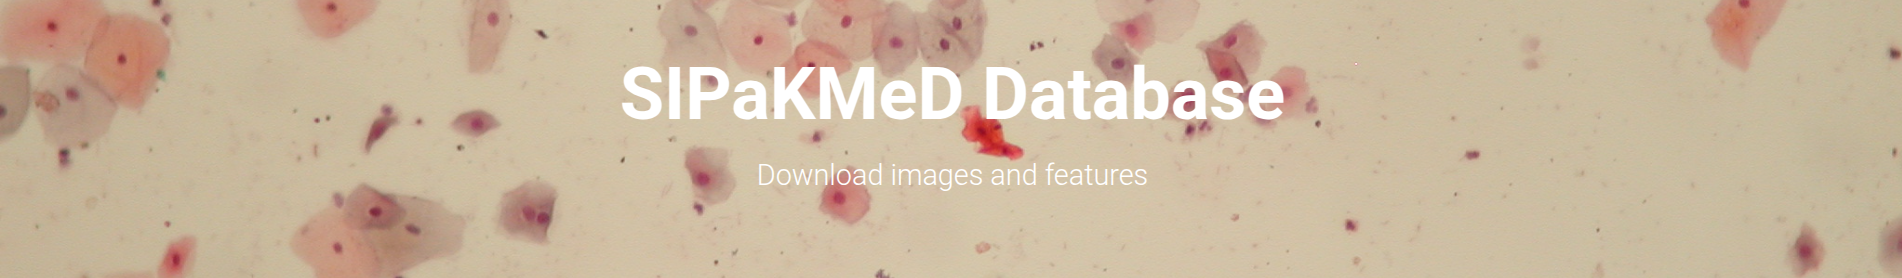

The SIPaKMeD database is publicly available and it can be used for experimental purposes with the request to cite the following paper:

**Marina E. Plissiti, Panagiotis Dimitrakopoulos, Giorgos Sfikas, Christophoros Nikou, Olga Krikoni, Antonia Charchanti, SIPAKMED: A new dataset for feature and image based classification of normal and pathological cervical cells in Pap smear images, IEEE International Conference on Image Processing (ICIP) 2018, Athens, Greece, 7-10 October 2018.**

In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join("../.."))
sys.path.append(PROJECT_ROOT)

PATH = os.path.abspath(os.path.join( "../../"))
sys.path.append(PATH)

PROJECT_PATH = os.path.abspath(os.path.join("../.."))
sys.path.append(PROJECT_PATH)

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import torch.optim as optim         
from matplotlib import pyplot as plt
from itertools import product
import torch.nn.functional as F

from utils.utils import set_seed, get_device, save_history, load_history
from src.uncertainty_Quantification.train import train_model,train_deep_ensemble, get_dataloader
from src.uncertainty_Quantification.test import evaluate_model, evaluate_deep_ensemble, evaluate_mc_dropout
from src.uncertainty_Quantification.models import SingleNetwork, MCDropoutNetwork, DeepEnsemble
from src.uncertainty_Quantification.losses import edl_mse_loss, edl_digamma_loss, edl_log_loss, relu_evidence 
from src.uncertainty_Quantification.models import FineTunedResNet50
from utils.utils import set_seed, enable_dropout
from src.uncertainty_Quantification.models import SingleNetwork, MCDropoutNetwork, DeepEnsemble
from sklearn.decomposition import PCA
import copy


from utils.utils import get_dataloaders
from src.uncertainty_Quantification.test import evaluate_model, monte_carlo_dropout, evaluate_mc_dropout
from netcal.binning import HistogramBinning
from netcal.scaling import TemperatureScaling, BetaCalibration
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from netcal.metrics import ECE
from netcal.presentation import ReliabilityDiagram
from utils.utils import enable_dropout, get_device



MODEL_SAVE_PATH = os.path.join(PROJECT_PATH, "outputs/models")
RESULTS_PATH = os.path.join(PROJECT_PATH, "outputs/calibration/")
DEVICE = get_device()
set_seed(42)
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
PATIENCE =10
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.0005
NB_EPOCHS = 50
NUM_SAMPLES, ENSEMBLE_SIZE = 5, 5


train_loader, val_loader, cal_loader, test_loader = get_dataloaders(batch_size=32, num_workers=4, model_type="resnet")

/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115370/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2025-04-05 06:57:39.250167: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 06:57:39.350747: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 06:57:39.439113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unab

**01. Load & Explore the Data**

In [3]:

DATASET_PATH = "../../datasets/SIPaKMeD"
IMG_SIZE = (224, 224)
def load_dataset(dataset_path):
    """
    Loads the dataset by scanning directories for `.bmp` images.
    Returns:
    - file_paths: Dict with class names as keys and list of image paths as values
    - class_counts: Dict with class names as keys and count of images as values
    """
    file_paths = {}
    class_counts = {}

    for class_name in sorted(os.listdir(dataset_path)):  
        class_dir = os.path.join(dataset_path, class_name, "CROPPED")
        if os.path.isdir(class_dir):
            bmp_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(".bmp")]
            file_paths[class_name] = bmp_files
            class_counts[class_name] = len(bmp_files)

    return file_paths, class_counts

def visualize_class_distribution(class_counts):
    """
    Plots a bar chart showing class distribution.
    """
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title("Class Distribution in SIPaKMeD Dataset")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=20)
    plt.show()
    
    

def plot_sample_images(file_paths, num_samples=5):
    """
    Plots sample images from each class.
    """
    fig, axes = plt.subplots(len(file_paths), num_samples, figsize=(num_samples * 2, len(file_paths) * 2))

    for i, (class_name, paths) in enumerate(file_paths.items()):
        sample_paths = np.random.choice(paths, num_samples, replace=False) if len(paths) >= num_samples else paths
        for j, img_path in enumerate(sample_paths):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=12, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


Class Counts: {'im_Dyskeratotic': 813, 'im_Koilocytotic': 825, 'im_Metaplastic': 793, 'im_Parabasal': 787, 'im_Superficial-Intermediate': 831}


/tmp/ipykernel_1683493/1212815650.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


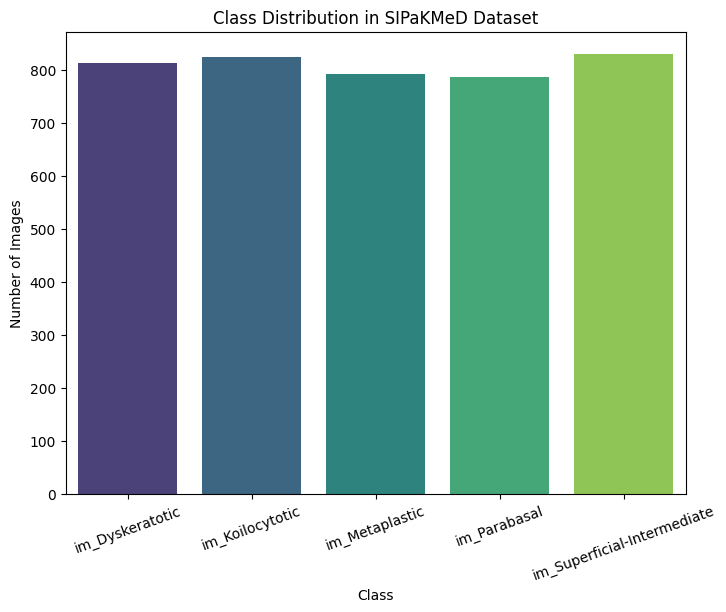

In [4]:
file_paths, class_counts = load_dataset(DATASET_PATH)
print(f"Class Counts: {class_counts}")
visualize_class_distribution(class_counts)


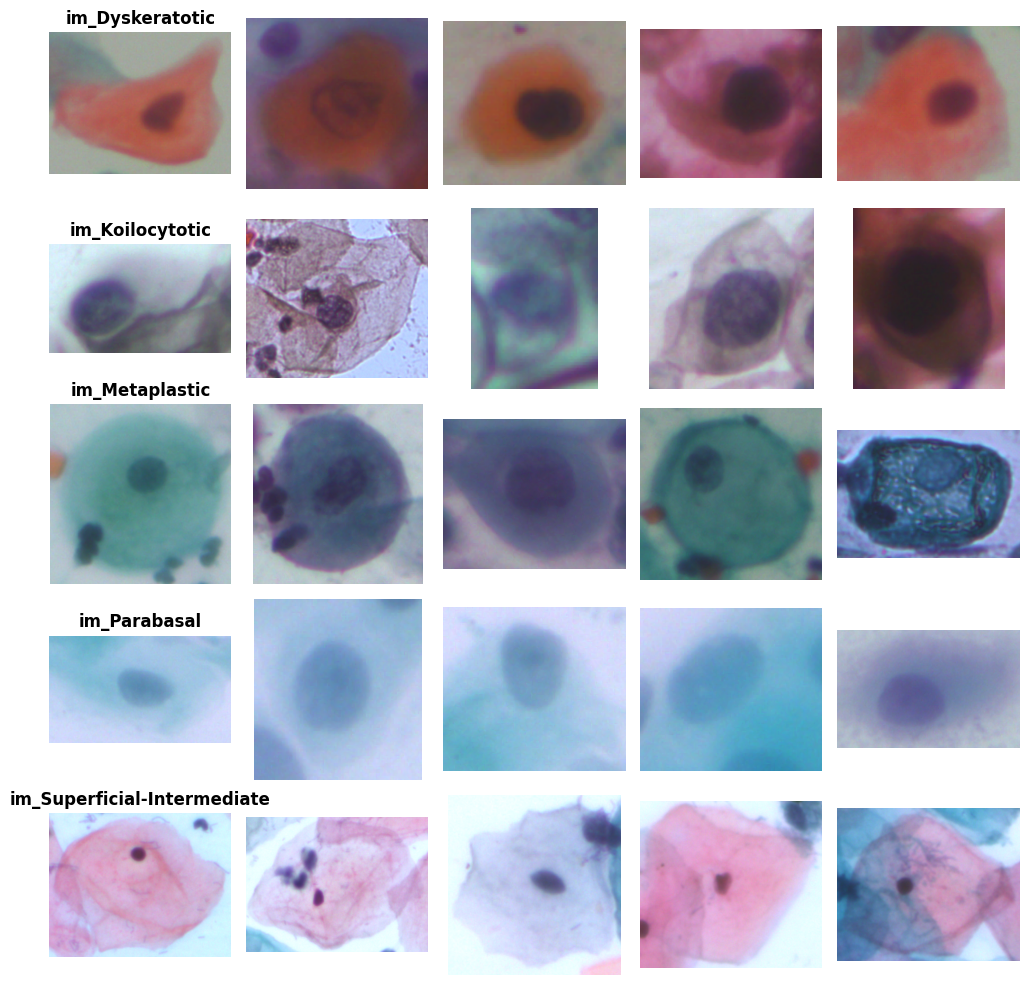

In [5]:
plot_sample_images(file_paths, num_samples=5)

# 1.0  

Evaluate and compare the classification accuracy, recall, precision, F1-score, and AUC achieved by Single Network, Monte Carlo Dropout (MCD), and Deep Ensemble (DE) on the three datasets 

In [6]:
def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

def compute_ece(y_true, y_probs, n_bins=10):
    confidences = np.max(y_probs, axis=1)
    predictions = np.argmax(y_probs, axis=1)
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower = bins[i]
        bin_upper = bins[i+1]
        bin_idx = np.where((confidences > bin_lower) & (confidences <= bin_upper))[0]
        if len(bin_idx) > 0:
            accuracy_in_bin = np.mean(predictions[bin_idx] == y_true[bin_idx])
            avg_confidence = np.mean(confidences[bin_idx])
            ece += (len(bin_idx) / len(y_true)) * abs(avg_confidence - accuracy_in_bin)
    return ece

def plot_reliability_diagram(y_true, y_probs, n_bins=10):
    confidences = np.max(y_probs, axis=1)
    predictions = np.argmax(y_probs, axis=1)
    prob_true, prob_pred = calibration_curve((y_true==predictions), confidences, n_bins=n_bins)
    plt.plot(prob_pred, prob_true, marker='o', label='Reliability')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
    plt.xlabel("Mean Predicted Confidence")
    plt.ylabel("True Accuracy")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.show()
    
    
    
class SingleNetworkEvaluator:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        
    def get_predictions(self, dataloader):
        self.model.eval()
        all_probs = []
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Single Network Evaluation", leave=False):
                inputs, labels = batch
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probs = F.softmax(outputs, dim=1)
                all_probs.append(probs.cpu().numpy())
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        all_probs = np.concatenate(all_probs)
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        return all_probs, all_preds, all_labels


class MCDApproachEvaluator:
    def __init__(self, model, device, num_passes=10):
        self.model = model.to(device)
        self.device = device
        self.num_passes = num_passes
        
    def get_predictions(self, dataloader):
        self.model.eval()
        enable_dropout(self.model)
        all_probs = []
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="MC Dropout Evaluation", leave=False):
                inputs, labels = batch
                inputs = inputs.to(self.device)
                mc_outputs = [self.model(inputs) for _ in range(self.num_passes)]
                outputs = torch.stack(mc_outputs, dim=0)
                probs = F.softmax(outputs, dim=2)
                mean_probs = probs.mean(dim=0)
                all_probs.append(mean_probs.cpu().numpy())
                preds = torch.argmax(mean_probs, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        all_probs = np.concatenate(all_probs)
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        return all_probs, all_preds, all_labels
    
class DeepEnsembleEvaluator:
    def __init__(self, models, device):
        self.models = [m.to(device) for m in models]
        self.device = device
        
    def get_predictions(self, dataloader):
        for m in self.models:
            m.eval()
        all_probs = []
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Deep Ensemble Evaluation", leave=False):
                inputs, labels = batch
                inputs = inputs.to(self.device)
                ensemble_outputs = [m(inputs) for m in self.models]
                outputs = torch.stack(ensemble_outputs, dim=0)
                probs = F.softmax(outputs, dim=2)
                mean_probs = probs.mean(dim=0)
                all_probs.append(mean_probs.cpu().numpy())
                preds = torch.argmax(mean_probs, dim=1)
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        all_probs = np.concatenate(all_probs)
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        return all_probs, all_preds, all_labels
   
class ResNetFineTunedPipeline:
    def __init__(self, train_loader, val_loader, test_loader, cal_loader, batch_size=32, num_epochs=50, learning_rate=0.0001, patience=10, dropout_rate=0.5, num_classes=5, device= torch.device("cuda" if torch.cuda.is_available() else "cpu"), num_mc_passes=10):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.cal_loader = cal_loader
        self.test_loader = test_loader
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.patience = patience
        self.dropout_rate = dropout_rate
        self.num_classes = num_classes
        self.device = device
        self.batch_size = batch_size
        self.num_mc_passes = num_mc_passes
        self.ensemble_size = self.num_mc_passes
        self.history = None
        self.best_model_path = None
        self.best_model = None
        self.ensemble_models = None
        
        # Initialize models for fine-tuning:
        self.base_model = self.initialize_model("resnet", mc_dropout=False)
        self.mcdropout_model = self.initialize_model("resnet", mc_dropout=True)
        self.seed = {
            "single": 42,
            "mc_dropout": 42,
            "deep_ensemble": [42 + i for i in range(self.ensemble_size)]
        }
        self.evaluators = {}
        self.criterion = nn.CrossEntropyLoss()
        self.results = {}
        print(f"Using Batch Size: {self.batch_size} | Learning Rate: {self.learning_rate} | Device: {self.device} | Dropout Rate: {self.dropout_rate} | Num Classes: {self.num_classes}")
        print(f"Train Loader Size: {len(self.train_loader.dataset)} | Cal Loader Size: {len(self.cal_loader.dataset)} | Val Loader Size: {len(self.val_loader.dataset)} | Test Loader Size: {len(self.test_loader.dataset)}")
        
    def initialize_model(self, model_type, mc_dropout=False):
        if model_type.lower() == "resnet":
            model = models.resnet50(pretrained=True)
            # Freeze all layers first
            for param in model.parameters():
                param.requires_grad = False
            # Unfreeze layer4 and fc
            for name, param in model.named_parameters():
                if "layer4" in name:
                    param.requires_grad = True
            num_features = model.fc.in_features
            if mc_dropout:
                dropout_layer = nn.Dropout(self.dropout_rate)
            else:
                dropout_layer = nn.Identity()
            model.fc = nn.Sequential(
                nn.Linear(num_features, 1024),
                nn.ReLU(),
                dropout_layer,
                nn.Linear(1024, 128),
                nn.ReLU(),
                nn.Linear(128, self.num_classes)
            )
            model = model.to(self.device)
            return model
        else:
            raise ValueError(f"Model type {model_type} not supported.")


    
    def create_ensemble(self):
        self.ensemble_models = []
        for i in range(self.ensemble_size):
            set_seed(self.seed["deep_ensemble"][i])
            torch.manual_seed(self.seed["deep_ensemble"][i])
            model = self.initialize_model("resnet", mc_dropout=False)
            self.ensemble_models.append(model)
        self.ensemble_models = [m.to(self.device) for m in self.ensemble_models]
        return self.ensemble_models

    def build_evaluators(self):
        single_eval = SingleNetworkEvaluator(self.base_model, self.device)
        mcd_eval = MCDApproachEvaluator(self.mcdropout_model, self.device, num_passes=self.num_mc_passes)
        deep_ensemble_eval = DeepEnsembleEvaluator(self.ensemble_models, self.device)
        self.evaluators = {
            'single': single_eval,
            'mc_dropout': mcd_eval,
            'deep_ensemble': deep_ensemble_eval
        }
        return self.evaluators

    
    def evaluate_classification(self):
        results = {}
        self.test_results = {}
        self.cal_results = {}
        y_true_test = []
        for batch in self.test_loader:
            _, labels = batch
            y_true_test.append(labels.cpu().numpy())
        y_true_test = np.concatenate(y_true_test, axis=0)
        
        y_true_cal = []
        for batch in self.cal_loader:
            _, labels = batch
            y_true_cal.append(labels.cpu().numpy())
        y_true_cal = np.concatenate(y_true_cal, axis=0)
        
        if not self.evaluators:
            self.build_evaluators()
        for name, evaluator in self.evaluators.items():
            print(f"Evaluating {name} approach on test set...")
            y_probas_test, y_preds_test, _ = evaluator.get_predictions(self.test_loader)
            metrics = self.compute_metrics(y_true_test, y_preds_test, y_probas_test)
            results[name] = metrics
            self.test_results[name] = {
                'y_true': y_true_test,
                'y_pred': y_preds_test,
                'y_probas': y_probas_test
            }
            print(f"{name} - Test Accuracy: {metrics['accuracy']:.3f} | Test F1: {metrics['f1_score']:.3f}")
            print(f"Compute y_probas, y_preds, y_true for calibration set.")
            y_probas_cal, y_preds_cal, _ = evaluator.get_predictions(self.cal_loader)
            self.cal_results[name] = {
                'y_true': y_true_cal,
                'y_pred': y_preds_cal,
                'y_probas': y_probas_cal
            }
            
            
        self.results = results
        return results
    
    # def compute_calibration_data(self):
    #     self.base_model.eval()
    #     cal_probs = []
    #     cal_labels = []
    #     with torch.no_grad():
    #         for batch in tqdm(self.cal_loader, desc="Calibration Data", leave=False):
    #             inputs, labels = batch
    #             inputs, labels = inputs.to(self.device), labels.to(self.device)
    #             outputs = self.base_model(inputs)
    #             probs = F.softmax(outputs, dim=1)
    #             cal_probs.append(probs.cpu().numpy())
    #             cal_labels.append(labels.cpu().numpy())
    #     self.cal_probs = np.concatenate(cal_probs, axis=0)
    #     self.cal_labels = np.concatenate(cal_labels, axis=0)
    #     print(f"Calibration data computed: {self.cal_probs.shape[0]} samples.")

    def multiclass_brier_score(self, y_true, y_probas):
        """
        Computes the multiclass Brier score.
        y_true: numpy array of shape (n_samples,) with class labels.
        y_probas: numpy array of shape (n_samples, n_classes) with predicted probabilities.
        """
        n_samples = y_true.shape[0]
        n_classes = y_probas.shape[1]
        y_true_onehot = np.zeros_like(y_probas)
        y_true_onehot[np.arange(n_samples), y_true] = 1
        return np.mean(np.sum((y_probas - y_true_onehot)**2, axis=1))

    def compute_metrics(self, y_true, y_pred, y_probas):
        res = {}
        res['accuracy'] = accuracy_score(y_true, y_pred)
        res['precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
        res['recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
        res['f1_score'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
        res['confusion_matrix'] = confusion_matrix(y_true, y_pred)
        
        try:
            res['brier_score'] = self.multiclass_brier_score(y_true, y_probas)
        except Exception as e:
            res['brier_score'] = None
            print("Brier score calculation error:", e)
        
        res['ece'] = compute_ece(y_true, y_probas, n_bins=10)
        try:
            res['auroc'] = roc_auc_score(y_true, y_probas, multi_class='ovr')
        except Exception as e:
            res['auroc'] = None
            print("AUC calculation error:", e)
        try:
            res['auprc'] = average_precision_score(y_true, y_probas, average='macro')
        except Exception as e:
            res['auprc'] = None
            print("AUPRC calculation error:", e)
        return res
    
    
    def tune_hyperparameters(self, evaluator, param_grid, val_loader, metric="f1_score", approach='mc_dropout'):
        best_config = None
        best_score = -np.inf
        y_true_all = []
        for batch in val_loader:
            _, labels = batch
            y_true_all.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true_all, axis=0)
        keys = list(param_grid.keys())
        for values in product(*param_grid.values()):
            config = dict(zip(keys, values))
            if approach == 'mc_dropout':
                evaluator.num_mc_passes = config.get('num_mc_passes', evaluator.num_mc_passes)
            # For other approaches, add tuning if needed.
            y_probas, y_preds, _ = evaluator.get_predictions(val_loader)
            metrics = self.compute_metrics(y_true, y_preds, y_probas)
            score = metrics.get(metric, 0)
            print(f"Config: {config} -> {metric}: {score:.3f}")
            if score > best_score:
                best_score = score
                best_config = config
        print("Best hyperparameters:", best_config, "with", metric, "=", best_score)
        return best_config

        
    def plot_reliability_diagram(self, y_true, y_probas, n_bins=10):
        plot_reliability_diagram(y_true, y_probas, n_bins=n_bins)
    
    def train_model(self, approach='single', dataset_name='sipakmed', type_model='resnet'):
        if approach == 'de':
            # Train a deep ensemble by training several independent models.
            ensemble_models = []
            for i in range(self.ensemble_size):
                print(f"Training ensemble member {i+1}/{self.ensemble_size}...")
                torch.manual_seed(self.seed["deep_ensemble"][i])
                model = self.initialize_model("resnet", mc_dropout=False)
                model = model.to(self.device)
                params_to_update = [p for p in model.parameters() if p.requires_grad]
                optimizer = optim.Adam(params_to_update, lr=self.learning_rate)
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.1, patience=self.patience, verbose=True
                )
                best_model_wts = copy.deepcopy(model.state_dict())
                best_val_loss = float('inf')
                best_val_acc = 0.0
                history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
                
                for epoch in range(self.num_epochs):
                    print(f"Epoch {epoch+1}/{self.num_epochs} for ensemble member {i+1}")
                    model.train()
                    running_loss = 0.0
                    running_corrects = 0
                    for inputs, labels in tqdm(self.train_loader, desc=f"Training | {approach}", leave=False):
                        inputs = inputs.to(self.device)
                        labels = labels.to(self.device)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = self.criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                        loss.backward()
                        optimizer.step()
                        
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                        
                    epoch_loss = running_loss / len(self.train_loader.dataset)
                    epoch_acc = running_corrects.double() / len(self.train_loader.dataset)
                    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                    history['train_loss'].append(epoch_loss)
                    history['train_acc'].append(epoch_acc.item())
                        
                    model.eval()
                    val_running_loss = 0.0
                    val_running_corrects = 0
                    with torch.no_grad():
                        for inputs, labels in tqdm(self.val_loader, desc="Validation", leave=False):
                            inputs = inputs.to(self.device)
                            labels = labels.to(self.device)
                            outputs = model(inputs)
                            loss = self.criterion(outputs, labels)
                            _, preds = torch.max(outputs, 1)
                            val_running_loss += loss.item() * inputs.size(0)
                            val_running_corrects += torch.sum(preds == labels.data)
                    val_loss = val_running_loss / len(self.val_loader.dataset)
                    val_acc = val_running_corrects.double() / len(self.val_loader.dataset)
                    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
                    history['val_loss'].append(val_loss)
                    history['val_acc'].append(val_acc.item())
                    scheduler.step(val_loss)
                    
                    # Save best model based on lowest val loss.
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_model_wts = copy.deepcopy(model.state_dict())
                        best_path = os.path.join(MODEL_SAVE_PATH, f"best_model_de_member_{dataset_name}_{type_model}_{approach}_{i}.pth")
                        torch.save(model.state_dict(), best_path)
                    print()
                print(f"Best Val Loss for ensemble member {i+1}: {best_val_loss:.4f} with Acc: {val_acc:.4f}")
                # Save final model after all epochs:
                final_path = os.path.join(MODEL_SAVE_PATH, f"final_model_de_member_{dataset_name}_{type_model}_{approach}_{i}.pth")
                torch.save(model.state_dict(), final_path)
                model.load_state_dict(best_model_wts)
                ensemble_models.append(model)
            self.ensemble_models = ensemble_models
            return ensemble_models

        elif approach == 'single':
            model = self.base_model
        elif approach == 'mc_dropout':
            model = self.mcdropout_model
        else:
            raise ValueError("Training approach not supported: " + approach)
        
        model = model.to(self.device)
        params_to_update = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.Adam(params_to_update, lr=self.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=self.patience, verbose=True
        )
        best_model_wts = copy.deepcopy(model.state_dict())
        best_val_loss = float('inf')
        best_acc = 0.0
        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        
        for epoch in range(self.num_epochs):
            print(f"Epoch {epoch+1}/{self.num_epochs}")
            model.train()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in tqdm(self.train_loader, desc=f"Training | {approach}", leave=False):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = self.criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(self.train_loader.dataset)
            epoch_acc = running_corrects.double() / len(self.train_loader.dataset)
            print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            self.history['train_loss'].append(epoch_loss)
            self.history['train_acc'].append(epoch_acc.item())
                
            model.eval()
            val_running_loss = 0.0
            val_running_corrects = 0
            with torch.no_grad():
                for inputs, labels in tqdm(self.val_loader, desc="Validation", leave=False):
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = model(inputs)
                    loss = self.criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    val_running_loss += loss.item() * inputs.size(0)
                    val_running_corrects += torch.sum(preds == labels.data)
            val_loss = val_running_loss / len(self.val_loader.dataset)
            val_acc = val_running_corrects.double() / len(self.val_loader.dataset)
            print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc.item())
            scheduler.step(val_loss)
            # Save best model if current val_loss is lower.
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                self.best_model_path = os.path.join(MODEL_SAVE_PATH, f"best_model_{dataset_name}_{type_model}_{approach}.pth")
                torch.save(model.state_dict(), self.best_model_path)
        
        print(f"Best Val Loss: {best_val_loss:.4f}")
        # Save final model after all epochs.
        final_model_path = os.path.join(MODEL_SAVE_PATH, f"final_model_{dataset_name}_{type_model}_{approach}.pth")
        torch.save(model.state_dict(), final_model_path)
        model.load_state_dict(best_model_wts)
        self.best_model = model
        return model


In [7]:
pipeline = ResNetFineTunedPipeline(
    train_loader=train_loader,
    val_loader=val_loader,
    cal_loader=cal_loader,
    test_loader=test_loader,
    batch_size=BATCH_SIZE,
    num_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    patience=PATIENCE,
    dropout_rate=DROPOUT_RATE,
    num_classes=5,
    device=DEVICE,
    num_mc_passes=NUM_SAMPLES
)

# single_finetuned_model = pipeline.train_model(approach='single')
# mcd_finetuned_model = pipeline.train_model(approach='mc_dropout')
# de_finetuned_models = pipeline.train_model(approach='de')

/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using Batch Size: 64 | Learning Rate: 0.0005 | Device: cpu | Dropout Rate: 0.5 | Num Classes: 5
Train Loader Size: 2834 | Cal Loader Size: 486 | Val Loader Size: 121 | Test Loader Size: 608


In [8]:
single_finetuned_model = pipeline.base_model
single_finetuned_model.load_state_dict(torch.load(MODEL_SAVE_PATH + "/output_single_resnet50_sipakmed.pth", map_location=torch.device('cpu')))
pipeline.base_model = single_finetuned_model

mcdropout_finetuned_model = pipeline.mcdropout_model
mcdropout_finetuned_model.load_state_dict(torch.load(MODEL_SAVE_PATH + "/output_mcdropout_resnet50_sipakmed.pth", map_location=torch.device('cpu')))
pipeline.mcdropout_model = mcdropout_finetuned_model

de_finetuned_models = pipeline.create_ensemble()
for i in range(len(de_finetuned_models)):
    de_finetuned_models[i].load_state_dict(torch.load(MODEL_SAVE_PATH + f"/output_deepensemble_resnet50_sipakmed_{i}.pth", map_location=torch.device('cpu')))
# Create evaluators for each approach
single_eval = SingleNetworkEvaluator(single_finetuned_model, DEVICE)
mcd_eval = MCDApproachEvaluator(mcdropout_finetuned_model, DEVICE, num_passes=NUM_SAMPLES)
de_eval = DeepEnsembleEvaluator(de_finetuned_models, DEVICE)
pipeline.ensemble_models = de_finetuned_models

# Evaluate each approach
results = pipeline.evaluate_classification()


/tmp/ipykernel_1683493/3951778311.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  single_finetuned_model.load_state_dict(torch.load(MODEL_SAVE_PATH + "/output_single_res

Evaluating single approach on test set...


single - Test Accuracy: 0.972 | Test F1: 0.972
Compute y_probas, y_preds, y_true for calibration set.


Evaluating mc_dropout approach on test set...


mc_dropout - Test Accuracy: 0.972 | Test F1: 0.972
Compute y_probas, y_preds, y_true for calibration set.


Evaluating deep_ensemble approach on test set...


deep_ensemble - Test Accuracy: 0.990 | Test F1: 0.990
Compute y_probas, y_preds, y_true for calibration set.


In [9]:
class SimplePerformancePlotter:
    def __init__(self, path_results, other_results=None):
        """
        Initialize with a dictionary of result file paths or lists of file paths.
        
        path_results: dict with keys:
          - 'single': path to single model JSON file
          - 'mc_dropout': path to MC Dropout JSON file
          - 'deep_ensemble': list of file paths for deep ensemble JSON files
        """
        self.path_results = path_results
        self.results = self.load_results()
        self.other_results = other_results
    
    def load_json(self, filepath):
        with open(filepath, 'r') as f:
            return json.load(f)
    
    def load_results(self):
        """
        For each approach (single, mc_dropout, deep_ensemble),
        load JSON data. If deep_ensemble has multiple files, average them.
        
        The JSON is expected to have:
          {
            "train_loss": [...],  # list of length num_epochs
            "val_loss": [...],
            "train_acc": [...],
            "val_acc": [...]
          }
        """
        results = {}
        for method, path in self.path_results.items():
            if method == 'deep_ensemble':
                ensemble_data = [self.load_json(p) for p in path]
                results[method] = self.average_arrays(ensemble_data)
            else:
                results[method] = self.load_json(path)
        return results

    def average_arrays(self, list_of_dicts):
        """
        Given a list of dictionaries that each contain arrays
        for 'train_loss', 'val_loss', 'train_acc', 'val_acc',
        we average them element-wise for each key.
        """
        if not list_of_dicts:
            return {}
        
        keys = list(list_of_dicts[0].keys())  
        avg_results = {}
        for k in keys:
            arrays = [np.array(d[k]) for d in list_of_dicts if k in d]
            if not arrays:
                avg_results[k] = None
                continue
            stacked = np.stack(arrays, axis=0)
            mean_array = np.mean(stacked, axis=0)
            avg_results[k] = mean_array.tolist()  
        return avg_results

    def plot_performance_curves(self):

        methods = list(self.results.keys())
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        metric_keys = [
            ("train_loss", axes[0,0], "Train Loss"),
            ("val_loss",   axes[0,1], "Val Loss"),
            ("train_acc",  axes[1,0], "Train Accuracy"),
            ("val_acc",    axes[1,1], "Val Accuracy")
        ]
        
        for method in methods:
            data = self.results[method]
            color = self.get_color_for_method(method)
            for (metric_name, ax, title) in metric_keys:
                if metric_name not in data or data[metric_name] is None:
                    continue
                values = np.array(data[metric_name])
                epochs = np.arange(1, len(values)+1)
                ax.plot(epochs, values, label=method, color=color)
                ax.set_title(title)
                ax.set_xlabel("Epoch")
                ax.grid(True)
        
        for (metric_name, ax, title) in metric_keys:
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        
    def plot_others_performance(self, results):
        """
        Plots key performance metrics as bar plots for each approach.
        """
        methods = list(results.keys())
        metrics_to_plot = ['accuracy', 'f1_score', 'recall', 'precision', 'ece', 'brier_score']
        num_metrics = len(metrics_to_plot)
        
        fig, axes = plt.subplots(1, num_metrics, figsize=(5*num_metrics, 5))
        
        for i, metric in enumerate(metrics_to_plot):
            metric_values = []
            for method in methods:
                value = results[method].get(metric)
                metric_values.append(value if value is not None else 0)
            # Plot as bars
            bars = axes[i].bar(methods, metric_values, color=['blue', 'orange', 'green'])
            axes[i].set_title(metric)
            if metric in ['accuracy', 'f1_score', 'recall', 'precision', 'ece']:
                axes[i].set_ylim(0, 1)
            axes[i].set_ylabel(metric)
            axes[i].set_xticks(range(len(methods)))
            axes[i].set_xticklabels(methods, rotation=45)
            axes[i].grid(True, axis='y')
            
            for bar, value in zip(bars, metric_values):
                axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                             f'{value:.2f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrices(self):
        """
        Plots the confusion matrices for each approach using seaborn heatmaps.
        Expects each approach's result to have a key 'confusion_matrix' (as a 2D list/array).
        """
        methods = list(self.other_results.keys())
        n_methods = len(methods)
        fig, axes = plt.subplots(1, n_methods, figsize=(5 * n_methods, 4))
        if n_methods == 1:
            axes = [axes]
        for i, method in enumerate(methods):
            cm = self.other_results[method].get("confusion_matrix")
            if cm is None:
                continue
            
            cm = np.array(cm)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f"Confusion Matrix: {method}")
            axes[i].set_xlabel("Predicted")
            axes[i].set_ylabel("True")
        plt.tight_layout()
        plt.show()
        
        
    def get_color_for_method(self, method):
        """
        Assign a consistent color for each approach (optional).
        """
        if method == 'single':
            return 'blue'
        elif method == 'mc_dropout':
            return 'orange'
        elif method == 'deep_ensemble':
            return 'green'
        else:
            return 'gray'
        
    


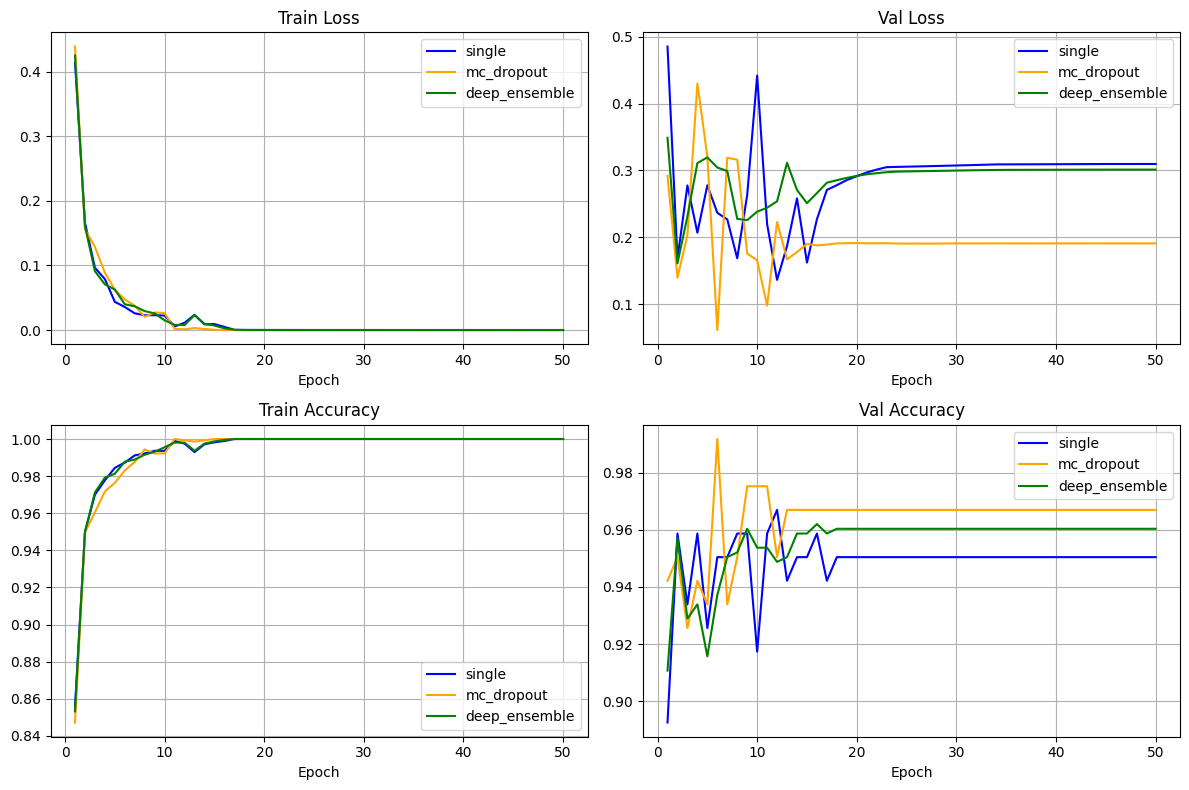

In [10]:

path_results = {
    'single': os.path.join(PATH, "outputs/models/output_single_resnet50_sipakmed.json"),
    'mc_dropout': os.path.join(PATH, "outputs/models/output_mcdropout_resnet50_sipakmed.json"),
    'deep_ensemble': [
        os.path.join(PATH, f"outputs/models/output_deepensemble_resnet50_sipakmed_{i}.json") 
        for i in range(ENSEMBLE_SIZE)
    ]
}

plotter = SimplePerformancePlotter(path_results, other_results=results)
plotter.plot_performance_curves()


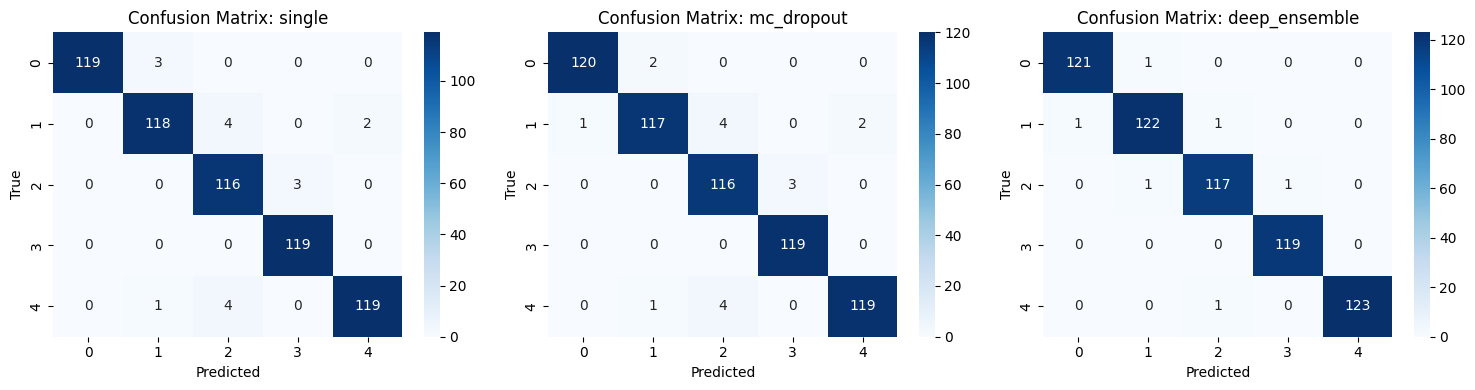

In [11]:
plotter.plot_confusion_matrices()

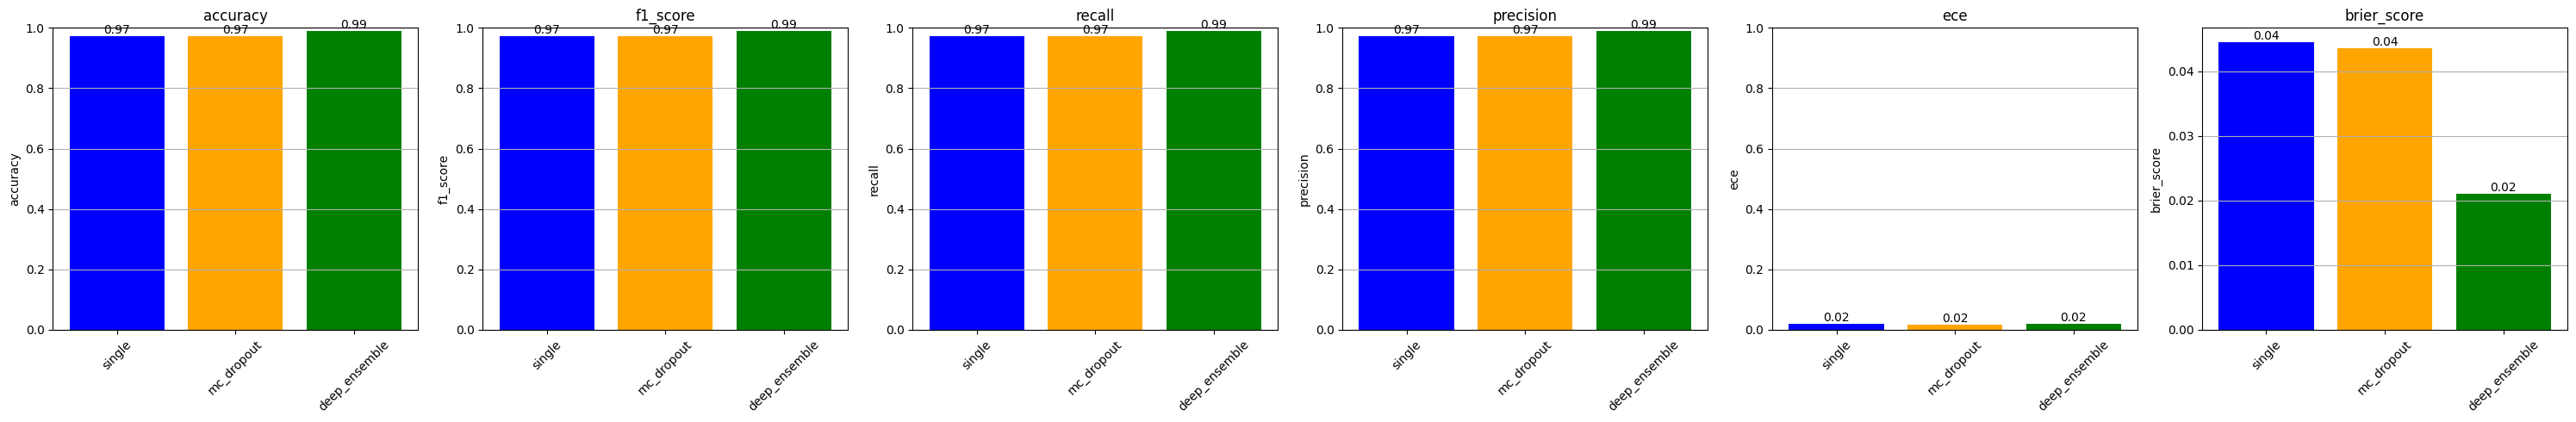

In [12]:
plotter.plot_others_performance(results)

# 2

In [13]:

class ReliabilityPlotter:
    def __init__(self, approaches_data):
        self.approaches_data = approaches_data
    
    def plot_all_approaches(self, n_bins=20):
        """
        Pour chaque approche dans approaches_data, trace un unique diagramme de fiabilité (Reliability Diagram).
        n_bins: nombre de bins à utiliser pour le diagramme de fiabilité.
        """
        for approach_name, (y_true, y_probs) in self.approaches_data.items():
            self.plot_reliability(approach_name, y_true, y_probs, n_bins=n_bins)
    
    def plot_reliability(self, approach_name, y_true, y_probs, n_bins=10):
        """
        Trace un unique diagramme de fiabilité (Reliability Diagram) pour l'approche spécifiée,
        en désactivant l'affichage de l'histogramme et de la légende netcal.
        """
        print(f"Plotting reliability diagram for approach: {approach_name}")
        fig = plt.figure(figsize=(6, 5))
        fig.suptitle(f"{approach_name.capitalize()} - Reliability Diagram", fontsize=14, y=0.97)

        rd = ReliabilityDiagram(
            bins=n_bins, 
            show_histogram=True, 
            show_title=True, 
            show_legend=True
        )
        rd.plot(y_probs, y_true)
        
        plt.xlabel("Confiance Moyenne")
        plt.ylabel("Exactitude")
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.grid(True, linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()

Plotting reliability diagram for approach: single


<Figure size 600x500 with 0 Axes>

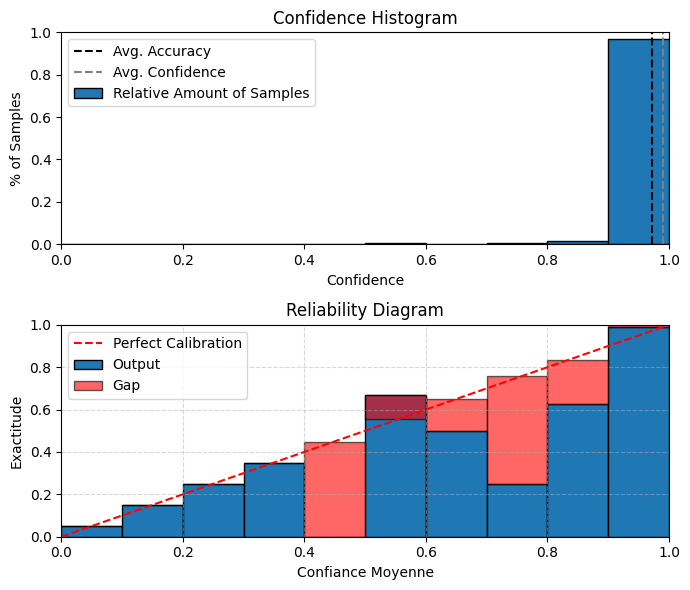

Plotting reliability diagram for approach: mc_dropout


<Figure size 600x500 with 0 Axes>

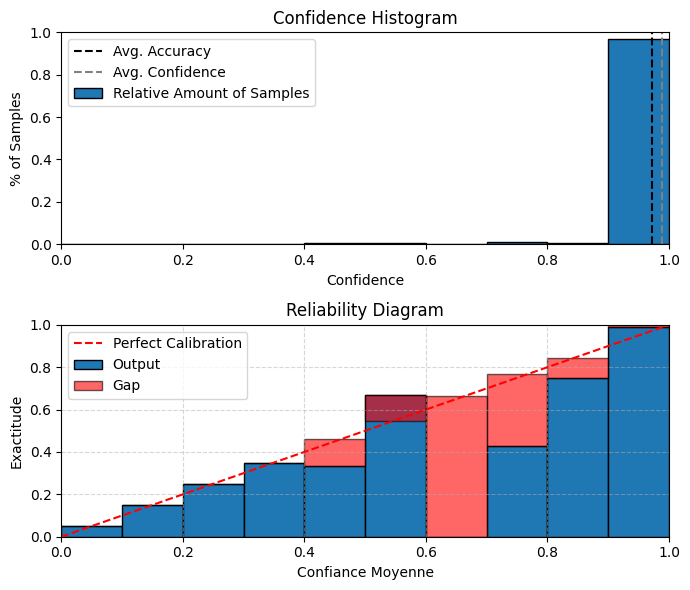

Plotting reliability diagram for approach: deep_ensemble


<Figure size 600x500 with 0 Axes>

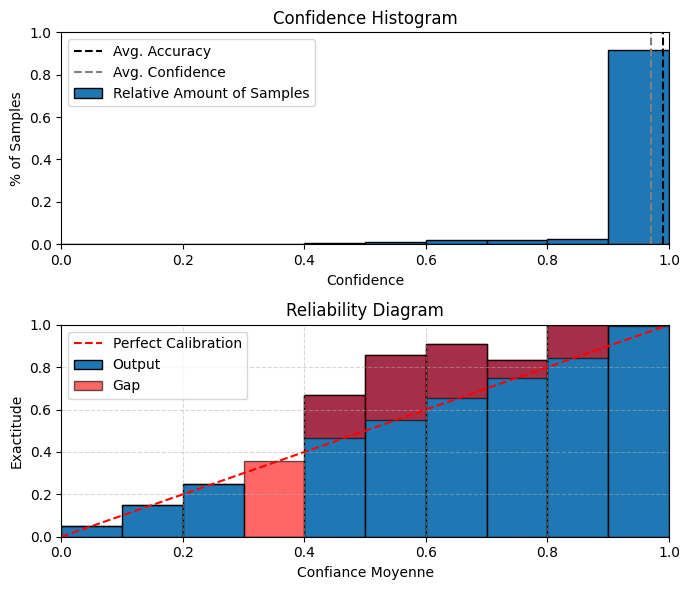

In [14]:
approaches_data = {
    'single': (pipeline.test_results['single']['y_true'], pipeline.test_results['single']['y_probas']),
    'mc_dropout': (pipeline.test_results['mc_dropout']['y_true'], pipeline.test_results['mc_dropout']['y_probas']),
    'deep_ensemble': (pipeline.test_results['deep_ensemble']['y_true'], pipeline.test_results['deep_ensemble']['y_probas'])
}


plotter = ReliabilityPlotter(approaches_data)
plotter.plot_all_approaches(n_bins=10)

* We note that almost all predictions have very high confidence (near 1.0).


# Step 3
For each base method's (SingleNet, MCD, DE), apply APS, RAPS, and SAPS to create conformal sets, then compare their mean/median set sizes, marginal coverage, etc... and accuracy-per-set-size trade-offs to come out with the most efficient combinaison strategy on the three datasets. 

In [15]:
import numpy as np
from scipy.stats import spearmanr, kruskal
from scipy.stats import entropy, ks_2samp




def entropy(probs):
	"""
	Calculate the entropy of a probability distribution.
	Supports both NumPy arrays and PyTorch tensors.
	"""
	if isinstance(probs, torch.Tensor):
		probs = probs.clamp(min=1e-12) 
		return -(probs * probs.log()).sum(dim=-1).item()
	elif isinstance(probs, np.ndarray):
		probs = np.clip(probs, 1e-12, 1.0) 
		return -np.sum(probs * np.log(probs), axis=-1)
	else:
		raise TypeError("Input must be a NumPy array or PyTorch tensor.")



class ConformalPredictor:
    def __init__(self, method='raps', lambda_param=1.0, k_reg=1, randomize=True):
        """
        Paramètres :
          - method : 'raps' ou 'saps'
          - lambda_param : hyperparamètre de régularisation (λ)
          - k_reg : paramètre de seuil pour la régularisation (k₍reg₎)
          - randomize : si True, on utilise la randomisation (u ~ U(0,1))
        """
        self.method = method.lower()
        self.lambda_param = lambda_param
        self.k_reg = k_reg
        self.randomize = randomize
        self.tau = None
        
        
    def _compute_aps_score(self, probs, true_label):
        """
        Calcule le score APS pour un échantillon de calibration.
        Selon la formule :
          score = π̂(x)[y] + λ·max(r - k_reg, 0)
        où π̂(x)[y] est la probabilité prédite pour la vraie classe y,
        et r est le rang (1-indexé) de y dans l'ordre décroissant.
        """
        sorted_indices = np.argsort(probs)[::-1]
        rank = np.where(sorted_indices == true_label)[0][0] + 1
        score = probs[true_label] + self.lambda_param * rank
        return score
    
    def _compute_raps_score(self, probs, true_label, u):
        """
        Calcule le score RAPS pour un échantillon de calibration.
        Selon la formule :
          score = ρ(x,y) + π̂(x)[y]·u + λ·max(r - k_reg, 0)
        où ρ(x,y) est la somme cumulée des probabilités des classes mieux classées que y,
        et r est le rang (1-indexé) de y dans l'ordre décroissant.
        """
        # Trier les indices par ordre décroissant
        sorted_indices = np.argsort(probs)[::-1]
        sorted_probs = probs[sorted_indices]
        # Trouver le rang de la classe vraie (1-indexé)
        rank = np.where(sorted_indices == true_label)[0][0] + 1
        rho = 0.0 if rank == 1 else np.sum(sorted_probs[:rank-1])
        score = rho + probs[true_label] * u + self.lambda_param * max(rank - self.k_reg, 0)
        return score

    def _compute_saps_score(self, probs, true_label, u):
        """
        Calcule le score SAPS pour un échantillon de calibration.
        Pour la classe ayant le rang 1, score = u * MSP.
        Sinon, score = MSP + (r - 2 + u)*λ,
        où MSP est la valeur maximale de la softmax, et r est le rang de la vraie classe.
        """
        max_prob = np.max(probs)
        sorted_indices = np.argsort(probs)[::-1]
        rank = np.where(sorted_indices == true_label)[0][0] + 1
        if rank == 1:
            score = u * max_prob
        else:
            score = max_prob + (rank - 2 + u) * self.lambda_param
        return score

    def calibrate(self, cal_probs, cal_labels, alpha=0.1):
        """
        Calibre le seuil τ à partir d'un jeu de calibration en utilisant la calibration split conformal.
        
        Pour chaque échantillon i du jeu de calibration, on calcule un score s_i selon la méthode choisie :
        - RAPS : score = _compute_raps_score(cal_probs[i], cal_labels[i], u)
        - SAPS : score = _compute_saps_score(cal_probs[i], cal_labels[i], u)
        - APS  : score = _compute_aps_score(cal_probs[i], cal_labels[i])
        
        Le seuil τ est alors défini comme le ⌈(n+1)(1-α)⌉‑ème plus petit score (en indice 0-indexé).
        
        :param cal_probs: array (n_samples, K) des probabilités prédites.
        :param cal_labels: array (n_samples,) des labels vrais.
        :param alpha: niveau d'erreur souhaité.
        :return: τ (seuil calibré)
        """
        scores = []
        n = len(cal_labels)
        for i in range(n):
            u = np.random.uniform(0, 1) if self.randomize else 0.5
            if self.method == 'raps':
                score = self._compute_raps_score(cal_probs[i], cal_labels[i], u)
            elif self.method == 'saps':
                score = self._compute_saps_score(cal_probs[i], cal_labels[i], u)
            elif self.method == 'aps':
                score = self._compute_aps_score(cal_probs[i], cal_labels[i])
            else:
                raise ValueError("Méthode non supportée : " + self.method)
            scores.append(score)
        scores = np.array(scores)
        sorted_scores = np.sort(scores)
        # Calcul de l'indice quantile : ceil((n+1)*(1-α))-1
        index = int(np.ceil((n + 1) * (1 - alpha))) - 1
        index = min(index, n - 1)
        self.tau = sorted_scores[index]
        return self.tau


    def predict(self, probs):
        """
        Génère l'ensemble de prédiction pour un échantillon de test dont le vecteur de probabilités est 'probs'.
        La procédure diffère selon la méthode :
        
        • Pour RAPS :
          - On trie les probabilités par ordre décroissant.
          - On cherche le plus petit entier L tel que la somme cumulée des probabilités des L premières classes
            plus λ·max(L - k_reg, 0) dépasse le seuil τ.
          - Une étape de randomisation ajuste éventuellement L.
          - L'ensemble de prédiction est alors constitué des L classes les mieux classées.
        
        • Pour SAPS :
          - On calcule pour chaque classe (en ordre décroissant) un score défini par :
              * Si la classe est la première : score = u * MSP,
              * Sinon : score = MSP + (r - 2 + u)*λ.
          - On choisit l'ensemble de prédiction comme les classes dont le score est inférieur ou égal à τ.
        """
        if self.tau is None:
            raise ValueError("Veuillez d'abord calibrer le prédicteur (méthode calibrate).")
        K = len(probs)
        
        if self.method == 'raps':
            sorted_indices = np.argsort(probs)[::-1]
            sorted_probs = probs[sorted_indices]
            cum_sum = 0.0
            L = 0
            for j in range(K):
                cum_sum += sorted_probs[j]
                penalty = self.lambda_param * max(j - self.k_reg, 0)
                if cum_sum + penalty > self.tau:    
                    L = j + 1
                    break
            # if L == 0:
            #     L = K
            if self.randomize:
                s_L = sorted_probs[L - 1]
                extra_penalty = self.lambda_param if (L > self.k_reg) else 0
                delta = (cum_sum + extra_penalty - self.tau) / (s_L + extra_penalty + 1e-12)

                if np.random.uniform(0, 1) >= delta and L > 1:
                    L = L - 1
            pred_set = sorted_indices[:L]
            return pred_set

        elif self.method == 'saps':
            sorted_indices = np.argsort(probs)[::-1]
            max_prob = np.max(probs)
            u_list = np.random.uniform(0, 1, size=K) if self.randomize else np.full(K, 0.5)
            scores = []
            # Calculer les scores pour chaque classe dans l'ordre décroissant
            for j, idx in enumerate(sorted_indices):
                rank = j + 1
                if rank == 1:
                    score = u_list[j] * max_prob
                else:
                    score = max_prob + (rank - 2 + u_list[j]) * self.lambda_param
                scores.append(score)
            scores = np.array(scores)
            # On choisit L comme le plus grand indice tel que le score reste inférieur ou égal à τ
            L = 0
            for j in range(K):
                if scores[j] <= self.tau:
                    L = j + 1
                else:
                    break
                
            # if L == 0:
            #     L = K
            pred_set = sorted_indices[:L]
            return pred_set
        elif self.method == 'aps':
            sorted_indices = np.argsort(probs)[::-1]
            sorted_probs = probs[sorted_indices]
            cum_sum = 0.0
            L = 0
            for j in range(K):
                cum_sum += sorted_probs[j]
                if cum_sum >= self.tau:
                    L = j + 1
                    break
            # if L == 0:
            #     L = K
            pred_set = sorted_indices[:L]
            return pred_set
        else:
            raise ValueError("Méthode non supportée : " + self.method)


    def tune_hyperparameters(self, cal_probs, cal_labels, alpha=0.1, lambda_grid=[0.1, 0.5, 0.75, 1.0], k_reg_grid=[1,2, 3, 4], show=True):
        """
        Recherche sur une grille les meilleurs hyperparamètres (λ et k_reg)
        qui minimisent la taille moyenne des ensembles de prédiction tout en assurant
        une couverture au moins égale à 1 - alpha sur le jeu de calibration.
        
        Calcule pour chaque combinaison :
        - La taille moyenne des ensembles (avg_size)
        - La couverture (coverage)
        - La perte = avg_size + pénalité (1000 si la couverture < 1 - alpha)
        
        Affiche ensuite une heatmap des pertes, avec annotations pour la couverture et la taille moyenne.
        
        Renvoie les meilleurs hyperparamètres (best_lambda, best_k_reg).
        """
        best_lambda = None
        best_k_reg = None
        best_loss = float('inf')
        n = len(cal_labels)
        
        losses = np.zeros((len(k_reg_grid), len(lambda_grid)))
        coverages = np.zeros((len(k_reg_grid), len(lambda_grid)))
        avg_sizes = np.zeros((len(k_reg_grid), len(lambda_grid)))
        
        for i, lam in enumerate(lambda_grid):
            for j, k in enumerate(k_reg_grid):
                self.lambda_param = lam
                self.k_reg = k
                # Calibrer avec les hyperparamètres actuels
                self.calibrate(cal_probs, cal_labels, alpha)
                # Générer les ensembles de prédiction sur le jeu de calibration
                all_sets = [self.predict(probs) for probs in cal_probs]
                coverage = np.mean([1 if y in s else 0 for s, y in zip(all_sets, cal_labels)])
                avg_size = np.mean([len(s) for s in all_sets])
                # Pénalité si la couverture n'est pas atteinte
                print(f"coverage = {coverage:.2f} | avg_size = {avg_size:.2f} | lambda = {lam} | k_reg = {k}")
                penalty = 1000 if coverage < (1 - alpha) else 0
                loss = avg_size + penalty
                losses[j, i] = loss
                coverages[j, i] = coverage
                avg_sizes[j, i] = avg_size
                
                if loss < best_loss:
                    best_loss = loss
                    best_lambda = lam
                    best_k_reg = k
        
        self.lambda_param = best_lambda
        self.k_reg = best_k_reg
        if show:
            fig, ax = plt.subplots(figsize=(8, 6))
            cax = ax.imshow(losses, interpolation='nearest', cmap='viridis', aspect='auto')
            ax.set_title("Recherche sur grille : Loss = avg_size + pénalité")
            ax.set_xlabel("Lambda")
            ax.set_ylabel("k_reg")
            ax.set_xticks(np.arange(len(lambda_grid)))
            ax.set_xticklabels(lambda_grid)
            ax.set_yticks(np.arange(len(k_reg_grid)))
            ax.set_yticklabels(k_reg_grid)
            fig.colorbar(cax, ax=ax)
            # Annoter chaque cellule avec la loss, la couverture et la taille moyenne
            for j in range(len(k_reg_grid)):
                for i in range(len(lambda_grid)):
                    text = f"{losses[j,i]:.2f}\nCov: {coverages[j,i]:.2f}\nSize: {avg_sizes[j,i]:.2f}"
                    ax.text(i, j, text, ha="center", va="center", color="w", fontsize=8)
            plt.tight_layout()
            plt.show()
        
        return best_lambda, best_k_reg

    
    @staticmethod
    def rejection_plot(test_probs, y_test, num_points=100):
        """
        Construit un rejection plot qui affiche l'exactitude en fonction du pourcentage de rejet
        basé sur l'entropie prédictive. Ici, le seuil de rejet est fixé au 25ème percentile (q1).
        
        Parameters:
            test_probs: array de dimension (n_samples, K)
            y_test: array des labels vrais
            num_points: nombre de points d'évaluation pour le rejet
            
        Affiche le plot.
        """
        entropies = np.array([entropy(prob) for prob in test_probs])
        q1 = np.percentile(entropies, 25)
        # Obtenir les prédictions (argmax)
        y_pred = np.array([np.argmax(prob) for prob in test_probs])
        # Pour le rejection plot, on utilisera q1 comme seuil de rejet
        sorted_idx = np.argsort(entropies)
        sorted_entropies = entropies[sorted_idx]

        results = {'acc': [], 'rejection_percent': []}
        seuil_reject = q1

        for percent in np.linspace(0, 1, num_points):
            # Sélectionner les indices dont l'entropie est inférieure ou égale au seuil
            filter_idx = sorted_idx[sorted_entropies <= seuil_reject]
            nb_items_to_complete = int(np.sum(entropies > seuil_reject) * (1 - percent))
            nb_items_needs = len(filter_idx) + nb_items_to_complete
            combined_indices = sorted_idx[:nb_items_needs]
            acc = np.sum(y_test[combined_indices] == y_pred[combined_indices]) / len(combined_indices)
            results['acc'].append(acc)
            results['rejection_percent'].append(percent)
        
        plt.figure(figsize=(8, 4))
        plt.plot(results['rejection_percent'], results['acc'], marker='o', label="Accuracy vs Rejection")
        plt.xlabel('Rejection Percent')
        plt.ylabel('Accuracy')
        plt.title("Rejection Plot: Entropy vs Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()
        return results
    

    @staticmethod
    def rejection_plot_with_kde_distribution(test_probs, y_test, num_points=100):
        """
        Produces a two-column figure:
        - Left: Rejection plot (accuracy vs. rejection percent) based on predictive entropy.
        - Right: Overlapping KDE plots of entropies for correct vs. wrong predictions,
                with vertical lines for their means. Also computes Cohen's d and KS test.

        Parameters:
        test_probs: array of shape (n_samples, K) with predicted probabilities
        y_test: array of shape (n_samples,) with true labels
        num_points: number of points for evaluating the rejection curve
        """
        # 1) Compute entropies and predictions
        entropies = np.array([entropy(prob) for prob in test_probs])
        y_pred = np.array([np.argmax(prob) for prob in test_probs])
        correctness = (y_test == y_pred).astype(int)

        sorted_idx = np.argsort(entropies)
        sorted_entropies = entropies[sorted_idx]
        q1 = np.percentile(entropies, 25) 
        seuil_reject = q1

        results = {'acc': [], 'rejection_percent': []}
        for percent in np.linspace(0, 1, num_points):
            filter_idx = sorted_idx[sorted_entropies <= seuil_reject]
            nb_items_to_complete = int(np.sum(entropies > seuil_reject) * (1 - percent))
            nb_items_needs = len(filter_idx) + nb_items_to_complete
            combined_indices = sorted_idx[:nb_items_needs]
            acc = np.sum(y_test[combined_indices] == y_pred[combined_indices]) / len(combined_indices)
            results['acc'].append(acc)
            results['rejection_percent'].append(percent)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
        ax_left, ax_right = axes

        # ---- LEFT SUBPLOT: Rejection Plot
        ax_left.plot(results['rejection_percent'], results['acc'], marker='o', label="Accuracy vs Rejection")
        ax_left.set_xlabel('Rejection Percent')
        ax_left.set_ylabel('Accuracy')
        ax_left.set_title("Rejection Plot: Entropy vs Accuracy")
        ax_left.legend()
        ax_left.grid(True, linestyle='--', alpha=0.5)

        # ---- RIGHT SUBPLOT: KDE distribution for correct vs. wrong
        correct_ents = entropies[correctness == 1]
        wrong_ents   = entropies[correctness == 0]

        mean_correct = np.mean(correct_ents)
        mean_wrong   = np.mean(wrong_ents)

        sns.kdeplot(correct_ents, shade=True, alpha=0.5, color='blue', label='Correct', ax=ax_right)
        sns.kdeplot(wrong_ents,   shade=True, alpha=0.5, color='red',  label='Incorrect', ax=ax_right)

        ax_right.axvline(mean_correct, color='blue', linestyle='--', label=f'Mean Correct: {mean_correct:.2f}')
        ax_right.axvline(mean_wrong,   color='red',  linestyle='--', label=f'Mean Wrong: {mean_wrong:.2f}')

        ax_right.set_xlabel("Entropy")
        ax_right.set_ylabel("Density")
        ax_right.set_title("Distribution of Entropies (Correct vs. Wrong)")
        ax_right.grid(True, linestyle='--', alpha=0.5)
        ax_right.legend()

        # 4) Compute effect size (Cohen's d) and KS test
        std_correct = np.std(correct_ents, ddof=1)
        std_wrong   = np.std(wrong_ents, ddof=1)
        n_correct   = len(correct_ents)
        n_wrong     = len(wrong_ents)
        pooled_std  = np.sqrt((std_correct**3 + std_wrong**3) / 2)
        cohen_d     = (mean_correct - mean_wrong) / pooled_std

        ks_stat, ks_p = ks_2samp(correct_ents, wrong_ents)

        print(f"Cohen's d = {cohen_d:.3f}")
        print(f"KS test statistic = {ks_stat:.3f}, p-value = {ks_p:.2e}")

        plt.tight_layout()
        plt.show()

        return {
            'rejection_curve': results,
            'cohen_d': cohen_d,
            'ks_stat': ks_stat,
            'ks_p': ks_p
        }



    @staticmethod
    def plot_correct_incorrect_bars(predictor_dict, test_probs, y_test):
        """
        Crée, pour chaque prédicteur (clé du dictionnaire), un histogramme empilé
        (stacked bar chart) où l'axe X = taille de l'ensemble de prédiction,
        l'axe Y = nombre d'échantillons, avec deux couleurs :
          - vert pour les échantillons correctement prédits (vrai label ∈ ensemble),
          - rouge pour les échantillons mal prédits (vrai label ∉ ensemble).

        predictor_dict : dict, ex:
            {
                'APS': predictor_aps,
                'RAPS': predictor_raps,
                'SAPS': predictor_saps
            }
            Chaque value est une instance de ConformalPredictor déjà calibrée.
        test_probs : array (n_samples, K)
        y_test : array des labels vrais (taille n_samples)
        """
        fig, axes = plt.subplots(1, len(predictor_dict), figsize=(5 * len(predictor_dict), 5), 
                                 sharey=True)

        if len(predictor_dict) == 1:
            axes = [axes]

        for i, (method_name, predictor) in enumerate(predictor_dict.items()):
            ax = axes[i]

            all_sets = [predictor.predict(prob) for prob in test_probs]
            set_sizes = [len(s) for s in all_sets]
            correctness = [1 if y in s else 0 for s, y in zip(all_sets, y_test)]
            # debug 
            unique_correctness = sorted(set(correctness))
            counts = [correctness.count(c) for c in unique_correctness]
            print(f"Counts for {method_name}: {counts}")
            coverage_mean = np.mean(correctness)
            # coverage_std = np.std(correctness)
            mean_set_size = np.mean(set_sizes)
            median_set_size = np.median(set_sizes)
            print(f"Coverage mean: {coverage_mean:.2f} | Set size mean: {mean_set_size:.2f} | Set size median: {median_set_size:.2f} | Set size std: {np.std(set_sizes):.2f}")
            
            # Regrouper par taille d'ensemble
            unique_sizes = sorted(set(set_sizes))
            correct_counts = []
            incorrect_counts = []

            for size in unique_sizes:
                indices = [idx for idx, val in enumerate(set_sizes) if val == size]
                nb_correct = sum(correctness[j] for j in indices)
                nb_incorrect = len(indices) - nb_correct
                correct_counts.append(nb_correct)
                incorrect_counts.append(nb_incorrect)

            # Création du bar chart empilé
            ax.bar(unique_sizes, correct_counts, color='green', label='Correct')
            ax.bar(unique_sizes, incorrect_counts, bottom=correct_counts, color='red', label='Incorrect')

            for x_val, c_val, i_val in zip(unique_sizes, correct_counts, incorrect_counts):
                if c_val > 0:
                    ax.text(x_val, c_val / 2, str(c_val), ha='center', va='center', color='white', fontsize=8)
                if i_val > 0:
                    ax.text(x_val, c_val + i_val / 2, str(i_val), ha='center', va='center', color='white', fontsize=8)

            ax.set_title(method_name, fontsize=12)
            ax.set_xlabel("Set Size")
            if i == 0:
                ax.set_ylabel("Number of Samples")
            ax.legend(loc='upper right')
            ax.grid(True, axis='y')

        plt.tight_layout()
        plt.show()
        
    def analyze_entropy_vs_set_size(self, test_probs, y_test):
        """
        Analyse la relation entre l'entropie prédictive et la taille de l'ensemble de prédiction.
        Affiche un scatter plot avec une ligne de régression.
        Les points verts représentent les ensembles contenant la classe correcte,
        tandis que les points rouges représentent les ensembles qui ne contiennent pas la classe correcte.
        """
        entropies = np.array([entropy(prob) for prob in test_probs])
        all_sets = [self.predict(prob) for prob in test_probs]
        set_sizes = np.array([len(s) for s in all_sets])
        correctness = np.array([1 if y in s else 0 for s, y in zip(all_sets, y_test)])

        plt.figure(figsize=(8, 5))
        for correct, color in zip([1, 0], ['green', 'red']):
            mask = correctness == correct
            plt.scatter(set_sizes[mask], entropies[mask], alpha=0.5, color=color, label="Correct" if correct else "Incorrect")
        plt.xlabel("Prediction Set Size")
        plt.ylabel("Predictive Entropy")
        plt.title("Scatter Plot: Entropy vs Set Size")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Corrélation de Spearman
        sp_corr, sp_p = spearmanr(entropies, set_sizes)
        print("Spearman correlation:", sp_corr, "p-value:", sp_p)

        # Test de Kruskal–Wallis en divisant en 3 groupes par quantiles
        q1, q2 = np.quantile(entropies, [0.33, 0.66])
        group1 = set_sizes[entropies <= q1]
        group2 = set_sizes[(entropies > q1) & (entropies <= q2)]
        group3 = set_sizes[entropies > q2]
        kw_stat, kw_p = kruskal(group1, group2, group3)
        print("Kruskal-Wallis stat:", kw_stat, "p-value:", kw_p)

        return {'entropies': entropies, 'set_sizes': set_sizes, 'correctness': correctness,
                'spearman_corr': sp_corr, 'spearman_p': sp_p, 'kw_stat': kw_stat, 'kw_p': kw_p}


    def analyze_entropy_vs_set_size_all_methods(self, predictor_dict, test_probs, y_test):
        """
        For each predictor in predictor_dict (e.g., APS, RAPS, SAPS), computes the predictive entropy 
        and the prediction set size for each sample in test_probs, then plots a scatter plot (one column per method)
        with:
        - x-axis: Prediction Set Size
        - y-axis: Predictive Entropy
        - Green points indicate that the prediction set contains the true label;
            Red points indicate otherwise.
        It also computes the Spearman correlation and performs a Kruskal–Wallis test (by dividing entropies into 3 groups)
        and prints these statistics.
        
        Parameters:
        predictor_dict: dict where keys are method names (e.g., 'APS', 'RAPS', 'SAPS')
                        and values are calibrated ConformalPredictor instances.
        test_probs: numpy array of shape (n_samples, K) with predicted probabilities.
        y_test: numpy array of true labels (n_samples,).
        
        Returns:
        results: dict mapping each method name to its computed 'entropies', 'set_sizes', and 'correctness'.
        """
        results = {}
        entropies = np.array([entropy(prob) for prob in test_probs])
        
        n_methods = len(predictor_dict)
        fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5), sharey=True)
        if n_methods == 1:
            axes = [axes]
        
        for idx, (method_name, predictor) in enumerate(predictor_dict.items()):
            if not hasattr(predictor, "tau") or predictor.tau is None:
                raise ValueError(f"Predictor for method {method_name} is not calibrated.")
            # Compute prediction set sizes for each sample using predictor.predict
            all_sets = [predictor.predict(prob) for prob in test_probs]
            set_sizes = np.array([len(s) for s in all_sets])
            correctness = np.array([1 if y in s else 0 for s, y in zip(all_sets, y_test)])
            results[method_name] = {'entropies': entropies, 'set_sizes': set_sizes, 'correctness': correctness}
            
            ax = axes[idx]
            # Plot scatter points: green for correct, red for incorrect
            for correct_val, color in zip([1, 0], ['green', 'red']):
                mask = correctness == correct_val
                ax.scatter(set_sizes[mask], entropies[mask], alpha=0.6, color=color, 
                        label="Correct" if correct_val==1 else "Incorrect")
            ax.set_title(method_name)
            ax.set_xlabel("Prediction Set Size")
            if idx == 0:
                ax.set_ylabel("Predictive Entropy")
            ax.grid(True, linestyle='--', alpha=0.5)
            
            # Compute Spearman correlation and Kruskal–Wallis test for set_sizes vs. entropies
            sp_corr, sp_p = spearmanr(entropies, set_sizes)
            q1, q2 = np.quantile(entropies, [0.33, 0.66])
            group1 = set_sizes[entropies <= q1]
            group2 = set_sizes[(entropies > q1) & (entropies <= q2)]
            group3 = set_sizes[entropies > q2]
            kw_stat, kw_p = kruskal(group1, group2, group3)
            print(f"Method: {method_name}")
            print("  Spearman correlation:", sp_corr, "p-value:", sp_p)
            print("  Kruskal-Wallis stat:", kw_stat, "p-value:", kw_p)
        
        plt.tight_layout()
        plt.show()
        
        return results


    def compute_set_size_stats(self, test_probs, y_test):
        """
        Calcule les statistiques de taille d'ensemble pour chaque prédicteur.
        Renvoie un DataFrame avec les tailles d'ensemble et les échantillons correspondants.
        """
        all_sets = [self.predict(prob) for prob in test_probs]
        set_sizes = np.array([len(s) for s in all_sets])
        coverage = np.array([1 if y in s else 0 for s, y in zip(all_sets, y_test)])
        
        return pd.DataFrame({
            'set_size': set_sizes,
            'correct': coverage
        })
    def plot_set_size_distribution(self, df):
        """
        Trace la distribution des tailles d'ensemble.
        df : DataFrame avec les colonnes 'set_size' et 'correct'.
        """
        plt.figure(figsize=(8, 5))
        sns.histplot(df['set_size'], bins=20, kde=True)
        plt.title("Distribution of Prediction Set Sizes")
        plt.xlabel("Set Size")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()
        

In [16]:
predictors = {
    'RAPS': ConformalPredictor(method='raps', lambda_param=0.5, k_reg=2, randomize=True),
    'SAPS': ConformalPredictor(method='saps', lambda_param=0.5, k_reg=2, randomize=True),
    'APS': ConformalPredictor(method='aps', lambda_param=0, k_reg=1, randomize=True)
}

approaches_names = ['single', 'mc_dropout', 'deep_ensemble']
for approach in approaches_names:
    print(f"<======================{approach} approach======================>")
    for predictor_name, predictor in predictors.items():
        if predictor_name == 'APS':
            continue
        print(f"Calibrating {predictor_name}")
        cal_probs = pipeline.cal_results[approach]['y_probas']
        cal_labels = pipeline.cal_results[approach]['y_true']
        predictor.tune_hyperparameters(cal_probs, cal_labels, alpha=0.1, show=False)
        print(f"Best lambda: {predictor.lambda_param}, Best k_reg: {predictor.k_reg}")
 

<======================single approach======================>
Calibrating RAPS
coverage = 0.99 | avg_size = 1.00 | lambda = 0.1 | k_reg = 1
coverage = 0.99 | avg_size = 1.01 | lambda = 0.1 | k_reg = 2
coverage = 0.99 | avg_size = 1.00 | lambda = 0.1 | k_reg = 3
coverage = 0.99 | avg_size = 1.01 | lambda = 0.1 | k_reg = 4
coverage = 0.99 | avg_size = 1.01 | lambda = 0.5 | k_reg = 1
coverage = 0.99 | avg_size = 1.01 | lambda = 0.5 | k_reg = 2
coverage = 0.99 | avg_size = 1.00 | lambda = 0.5 | k_reg = 3
coverage = 0.99 | avg_size = 1.01 | lambda = 0.5 | k_reg = 4
coverage = 0.99 | avg_size = 1.01 | lambda = 0.75 | k_reg = 1
coverage = 0.99 | avg_size = 1.01 | lambda = 0.75 | k_reg = 2
coverage = 0.99 | avg_size = 1.01 | lambda = 0.75 | k_reg = 3
coverage = 0.99 | avg_size = 1.01 | lambda = 0.75 | k_reg = 4
coverage = 0.99 | avg_size = 1.01 | lambda = 1.0 | k_reg = 1
coverage = 0.99 | avg_size = 1.00 | lambda = 1.0 | k_reg = 2
coverage = 0.99 | avg_size = 1.00 | lambda = 1.0 | k_reg = 3
co

In [17]:
predictors = {
    'RAPS': ConformalPredictor(method='raps', lambda_param=0.75, k_reg=2, randomize=True),
    'SAPS': ConformalPredictor(method='saps', lambda_param=0.75, k_reg=2, randomize=True),
    'APS': ConformalPredictor(method='raps', lambda_param=0, k_reg=1, randomize=True)
}
for predictor_name, predictor in predictors.items():
    print(f"Calibrating {predictor_name}")
    cal_probs = pipeline.cal_results['single']['y_probas']
    cal_labels = pipeline.cal_results['single']['y_true']
    predictor.calibrate(cal_probs, cal_labels)
    print(f"Best tau: {predictor.tau}")


Calibrating RAPS
Best tau: 0.9142361568479402
Calibrating SAPS
Best tau: 0.8746841538988478
Calibrating APS
Best tau: 0.9133845103649044


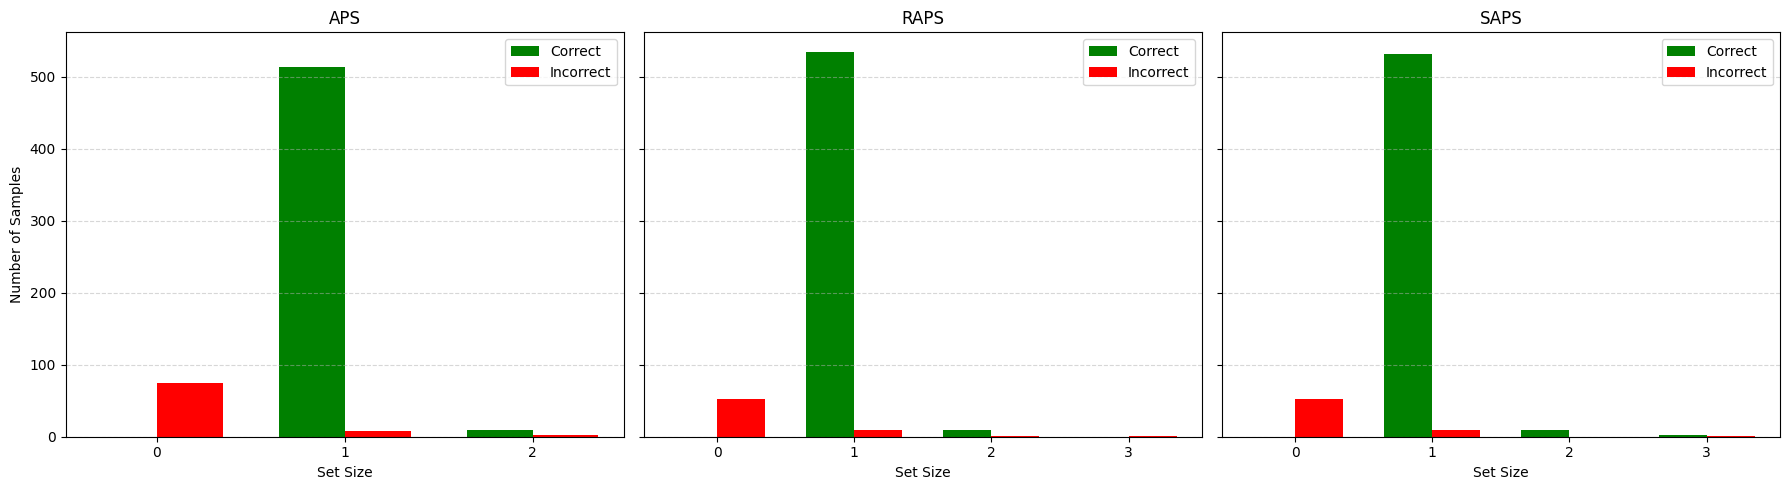

In [18]:
import torch
import numpy as np
from collections import defaultdict
from torchcp.classification.predictor import SplitPredictor
from torchcp.classification.score import APS, RAPS, SAPS
import matplotlib.pyplot as plt

def predict_entire_testset(pipeline, split_predictor):
    x_list = []
    labels_list = []
    for batch in pipeline.test_loader:
        x, y = batch
        x_list.append(x)
        labels_list.append(y)
    
    X_test = torch.cat(x_list, dim=0)       
    Y_test = torch.cat(labels_list, dim=0)  
    Y_test_np = Y_test.cpu().numpy()
    
    
    split_predictor.calibrate(pipeline.cal_loader, alpha=0.1)
    pred_sets = split_predictor.predict(x_batch=X_test)
    
    set_sizes = []
    corrects = []
    for i in range(len(Y_test_np)):
        predicted_indices = np.where(pred_sets[i] == 1)[0]  # predicted classes
        set_size = len(predicted_indices)
        is_correct = 1 if Y_test_np[i] in predicted_indices else 0
        set_sizes.append(set_size)
        corrects.append(is_correct)
    
    return np.array(set_sizes), np.array(corrects)

def plot_correct_incorrect_distribution_all(results):
    """
    Plots a bar chart for each approach (APS, RAPS, SAPS) in a single row.
    results: dict where keys are method names and values are tuples (set_sizes, corrects).
    """
    methods = list(results.keys())
    n_methods = len(methods)
    
    fig, axes = plt.subplots(1, n_methods, figsize=(6 * n_methods, 5), sharey=True)
    if n_methods == 1:
        axes = [axes]
    
    for idx, method in enumerate(methods):
        set_sizes, corrects = results[method]
        stats = defaultdict(lambda: [0, 0])
        for size, corr in zip(set_sizes, corrects):
            stats[size][0] += corr
            stats[size][1] += 1
        
        unique_sizes = sorted(stats.keys())
        correct_counts = [stats[s][0] for s in unique_sizes]
        incorrect_counts = [stats[s][1] - stats[s][0] for s in unique_sizes]
        
        x = np.arange(len(unique_sizes))
        width = 0.35
        ax = axes[idx]
        ax.bar(x - width/2, correct_counts, width, color='green', label='Correct')
        ax.bar(x + width/2, incorrect_counts, width, color='red', label='Incorrect')
        
        ax.set_xticks(x)
        ax.set_xticklabels(unique_sizes)
        ax.set_xlabel('Set Size')
        if idx == 0:
            ax.set_ylabel('Number of Samples')
        ax.set_title(method)
        ax.legend()
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

split_predictor_aps = SplitPredictor(
    score_function=APS(),
    model=single_finetuned_model
)
split_predictor_raps = SplitPredictor(
    score_function=RAPS(randomized=True, kreg=2),
    model=single_finetuned_model
)
split_predictor_saps = SplitPredictor(
    score_function=SAPS(randomized=True),
    model=single_finetuned_model
)
set_sizes_aps, corrects_aps = predict_entire_testset(pipeline, split_predictor_aps)
set_sizes_raps, corrects_raps = predict_entire_testset(pipeline, split_predictor_raps)
set_sizes_saps, corrects_saps = predict_entire_testset(pipeline, split_predictor_saps)

results = {
    'APS': (set_sizes_aps, corrects_aps),
    'RAPS': (set_sizes_raps, corrects_raps),
    'SAPS': (set_sizes_saps, corrects_saps)
}

plot_correct_incorrect_distribution_all(results)


 <======================Single approach======================>
Counts for RAPS: [12, 596]
Coverage mean: 0.98 | Set size mean: 1.02 | Set size median: 1.00 | Set size std: 0.18
Counts for SAPS: [91, 517]
Coverage mean: 0.85 | Set size mean: 0.88 | Set size median: 1.00 | Set size std: 0.34
Counts for APS: [13, 595]
Coverage mean: 0.98 | Set size mean: 1.02 | Set size median: 1.00 | Set size std: 0.16


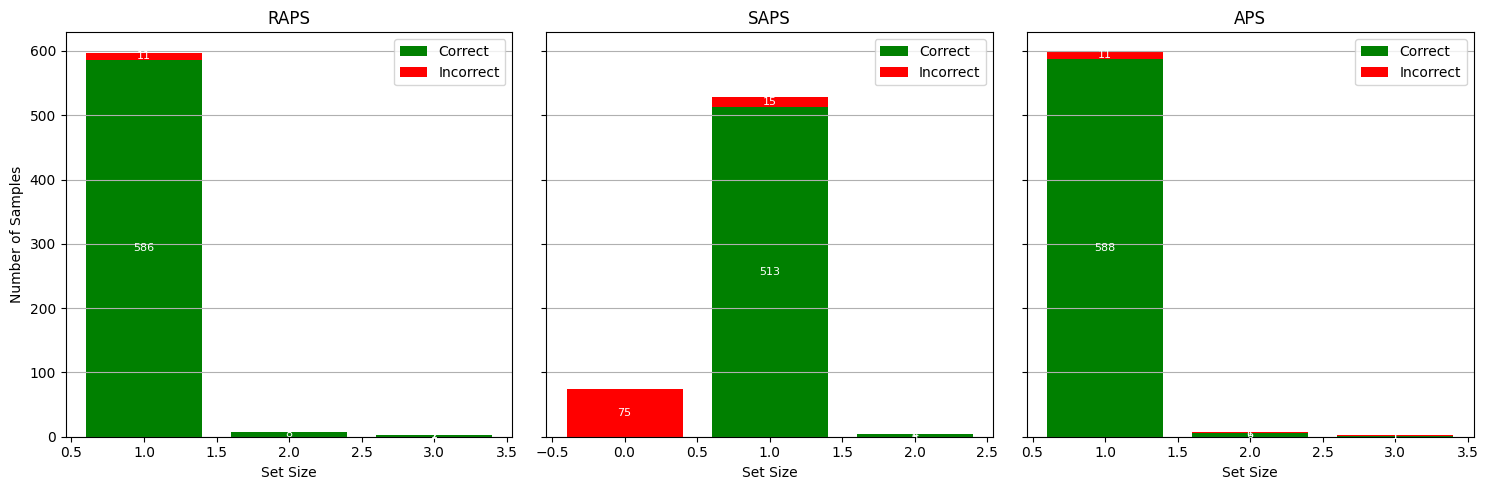

In [19]:
print(f" <======================Single approach======================>")
ConformalPredictor.plot_correct_incorrect_bars(
    predictors,
    test_probs=pipeline.test_results['single']['y_probas'],
    y_test=pipeline.test_results['single']['y_true']
)
# pipeline.results['single']

 <======================MC Dropout approach======================>
Counts for RAPS: [14, 594]
Coverage mean: 0.98 | Set size mean: 1.02 | Set size median: 1.00 | Set size std: 0.16
Counts for SAPS: [85, 523]
Coverage mean: 0.86 | Set size mean: 0.89 | Set size median: 1.00 | Set size std: 0.33
Counts for APS: [15, 593]
Coverage mean: 0.98 | Set size mean: 1.01 | Set size median: 1.00 | Set size std: 0.13


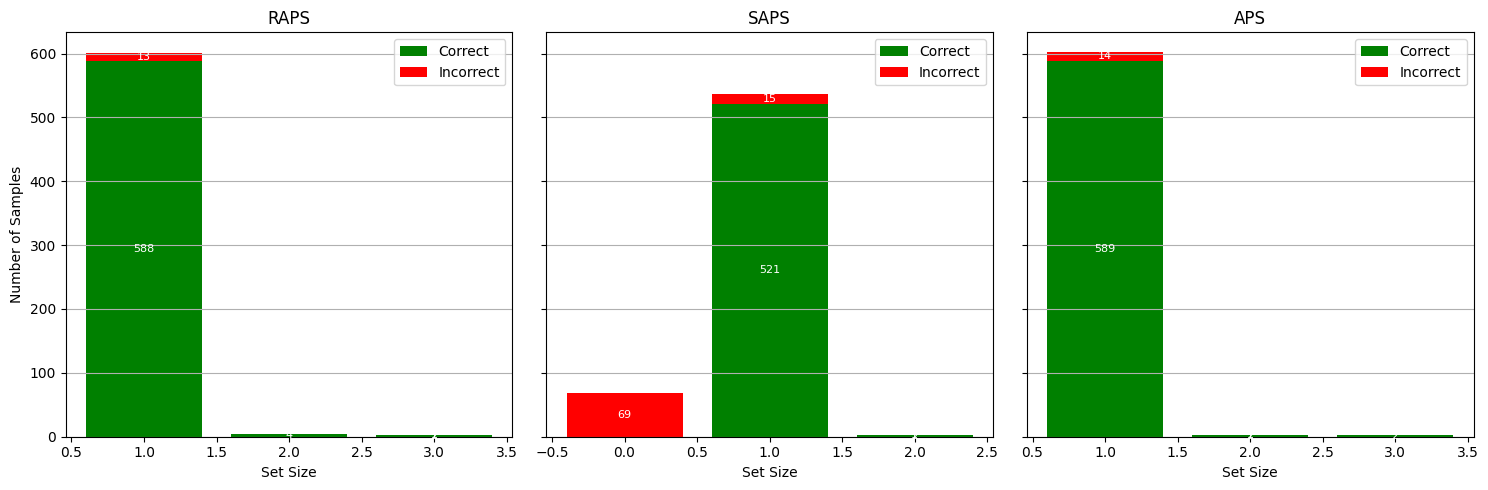

In [20]:
print(f" <======================MC Dropout approach======================>")
ConformalPredictor.plot_correct_incorrect_bars(
    predictors,
    test_probs=pipeline.test_results['mc_dropout']['y_probas'],
    y_test=pipeline.test_results['mc_dropout']['y_true']
)

 <======================Deep Ensemble approach======================>
Counts for RAPS: [5, 603]
Coverage mean: 0.99 | Set size mean: 1.05 | Set size median: 1.00 | Set size std: 0.28
Counts for SAPS: [64, 544]
Coverage mean: 0.89 | Set size mean: 0.92 | Set size median: 1.00 | Set size std: 0.34
Counts for APS: [4, 604]
Coverage mean: 0.99 | Set size mean: 1.05 | Set size median: 1.00 | Set size std: 0.24


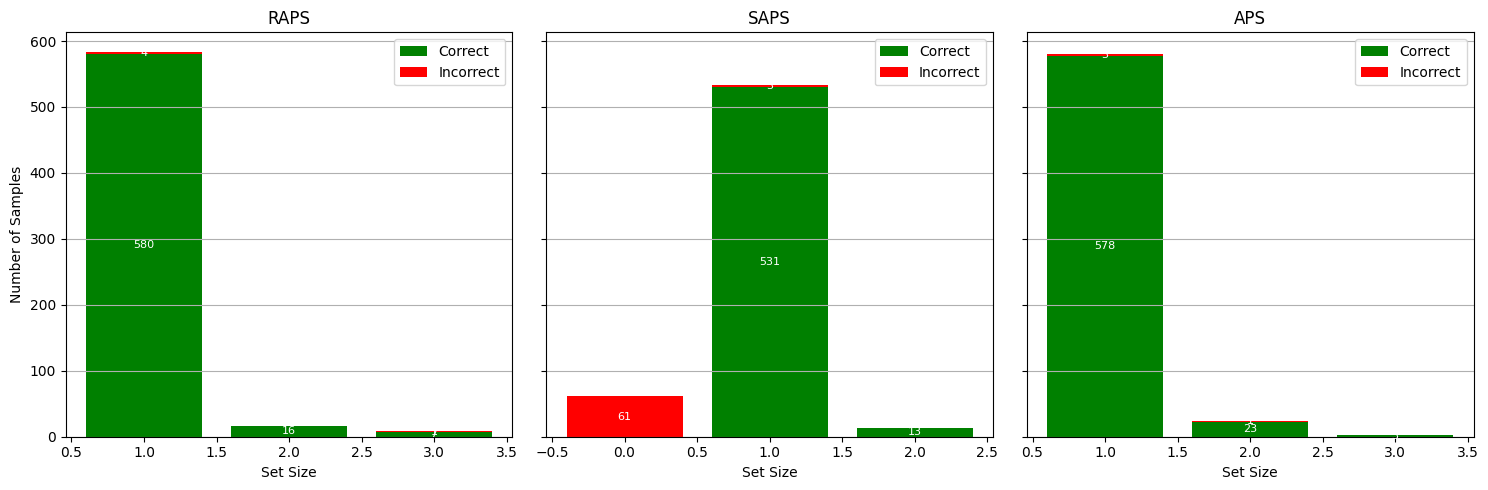

In [21]:
print(f" <======================Deep Ensemble approach======================>")
ConformalPredictor.plot_correct_incorrect_bars(
    predictors,
    test_probs=pipeline.test_results['deep_ensemble']['y_probas'],
    y_test=pipeline.test_results['deep_ensemble']['y_true']
)

## Step 4
Investigate how predictive entropy correlates with classification performance for each method, quantify effect sizes (using KS tests and Cohen's d), and visualize rejection plots to see which approach exhibits the strongest relationship between uncertainty and accuracy 

<======================single approach======================>
Cohen's d = -2.874
KS test statistic = 0.828, p-value = 6.74e-13


/tmp/ipykernel_1683493/2182991627.py:380: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(correct_ents, shade=True, alpha=0.5, color='blue', label='Correct', ax=ax_right)
/tmp/ipykernel_1683493/2182991627.py:381: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(wrong_ents,   shade=True, alpha=0.5, color='red',  label='Incorrect', ax=ax_right)


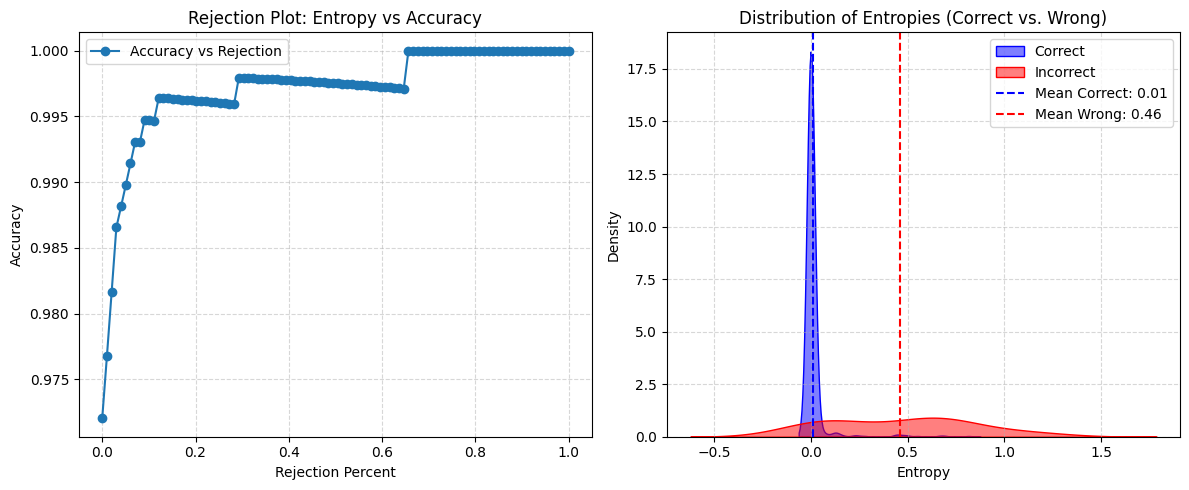

<======================mc_dropout approach======================>
Cohen's d = -3.086
KS test statistic = 0.821, p-value = 1.28e-12


/tmp/ipykernel_1683493/2182991627.py:380: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(correct_ents, shade=True, alpha=0.5, color='blue', label='Correct', ax=ax_right)
/tmp/ipykernel_1683493/2182991627.py:381: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(wrong_ents,   shade=True, alpha=0.5, color='red',  label='Incorrect', ax=ax_right)


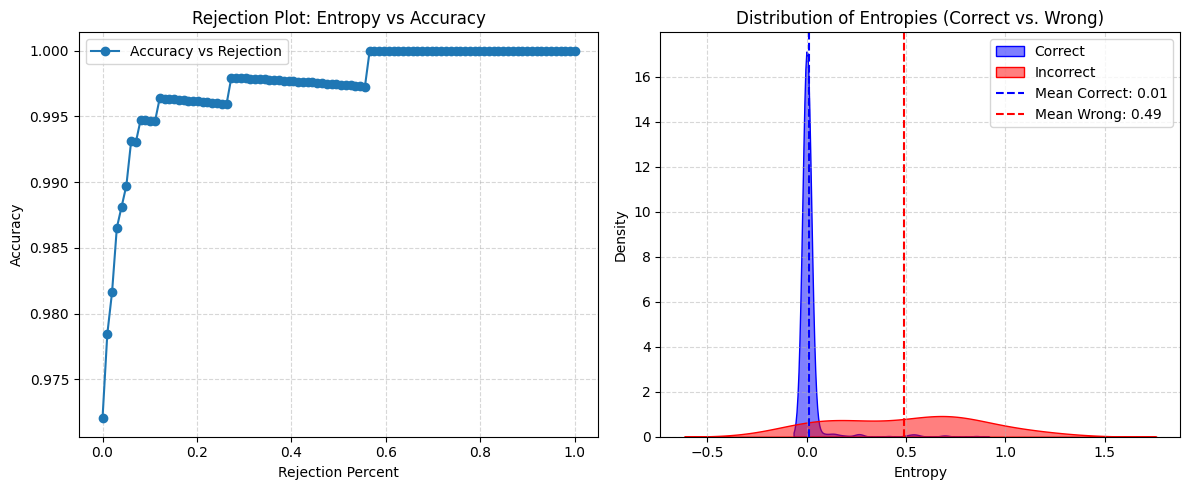

<======================deep_ensemble approach======================>
Cohen's d = -6.277
KS test statistic = 0.958, p-value = 2.15e-08


/tmp/ipykernel_1683493/2182991627.py:380: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(correct_ents, shade=True, alpha=0.5, color='blue', label='Correct', ax=ax_right)
/tmp/ipykernel_1683493/2182991627.py:381: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(wrong_ents,   shade=True, alpha=0.5, color='red',  label='Incorrect', ax=ax_right)


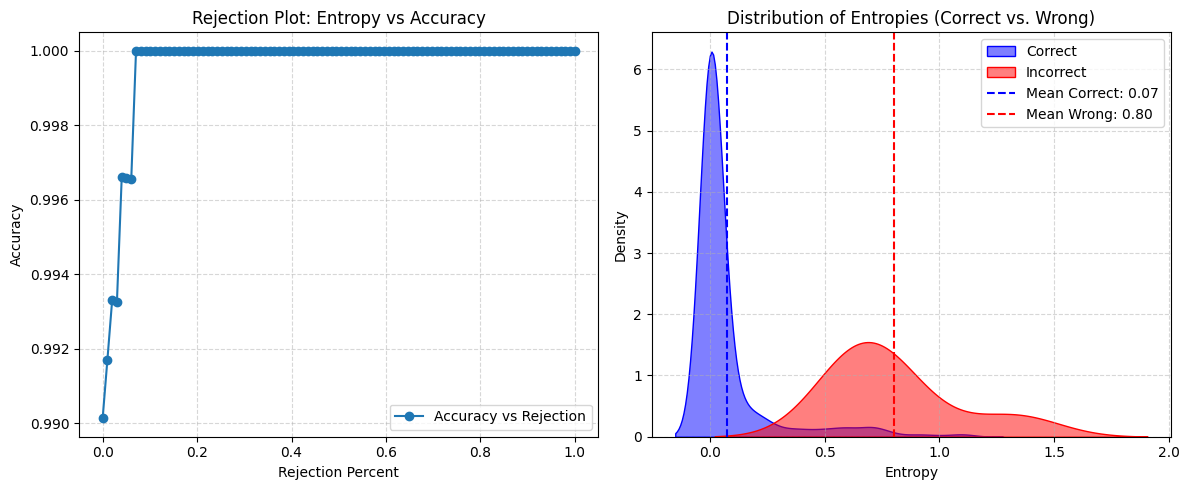

In [22]:
for approach in approaches_names:
    print(f"<======================{approach} approach======================>")
    ConformalPredictor.rejection_plot_with_kde_distribution(
        pipeline.test_results[approach]['y_probas'], 
        pipeline.test_results[approach]['y_true'],
        num_points=100
    )


# Step 5
Investigate the correlation between predictive entropy and predictive set size by using the scatter plot, Kruskal Wallis test and spearman rank correlation coefficient to identify among SingleNet, MCD and DE the ones which produce the more aligned uncertainty measure 

In [23]:
predictor_dict = {
    'APS': predictors['APS'],
    'RAPS': predictors['RAPS'],
    'SAPS': predictors['SAPS']
}

 <======================Single approach======================>
Method: APS
  Spearman correlation: 0.19766002500047009 p-value: 8.999163747176566e-07
  Kruskal-Wallis stat: 15.678088853512621 p-value: 0.00039404540004804155
Method: RAPS
  Spearman correlation: 0.19792667267112354 p-value: 8.693856570008291e-07
  Kruskal-Wallis stat: 15.677745049911264 p-value: 0.0003941131429842587
Method: SAPS
  Spearman correlation: 0.08253488399985791 p-value: 0.04191120630953472
  Kruskal-Wallis stat: 4.722932646519745 p-value: 0.09428187408387677


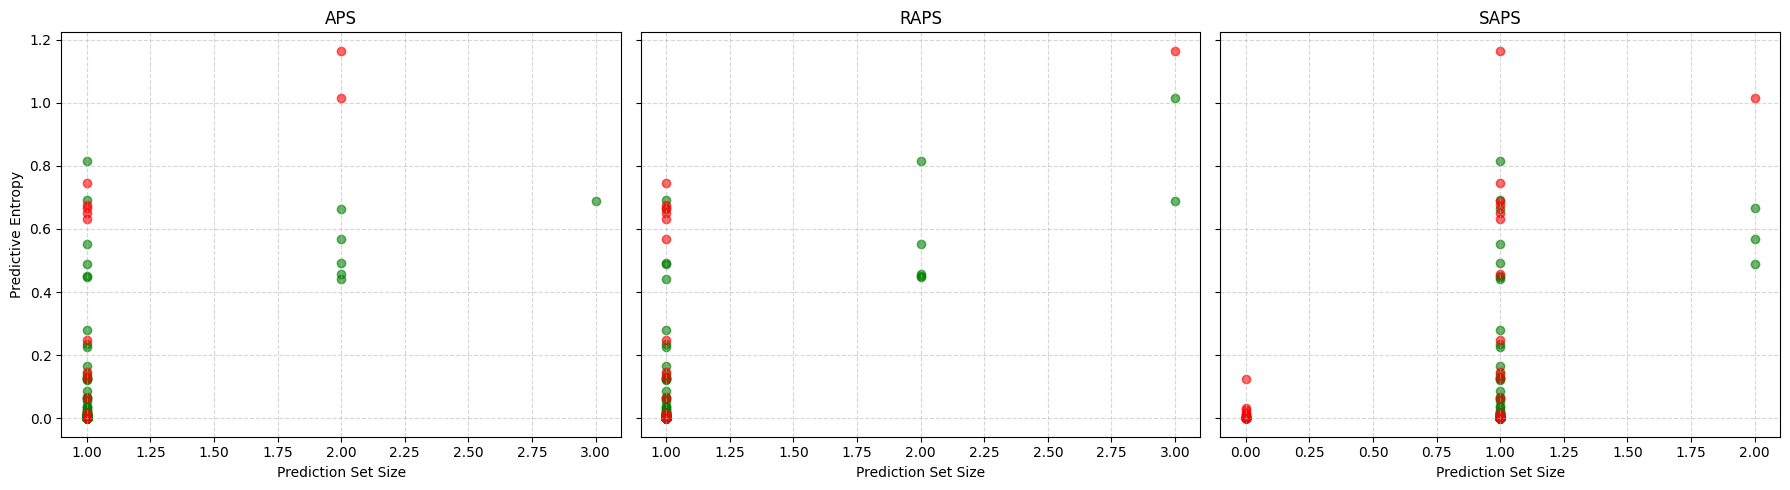

 <======================Deep Ensemble approach======================>
Method: APS
  Spearman correlation: 0.34723224356644866 p-value: 1.1423362153336272e-18
  Kruskal-Wallis stat: 56.75451274074796 p-value: 4.741482443239342e-13
Method: RAPS
  Spearman correlation: 0.3274890077482612 p-value: 1.1504281185182164e-16
  Kruskal-Wallis stat: 50.405719989868636 p-value: 1.1338013663342666e-11
Method: SAPS
  Spearman correlation: 0.19591081281449607 p-value: 1.1272720994119768e-06
  Kruskal-Wallis stat: 17.588997542633262 p-value: 0.0001515645772564796


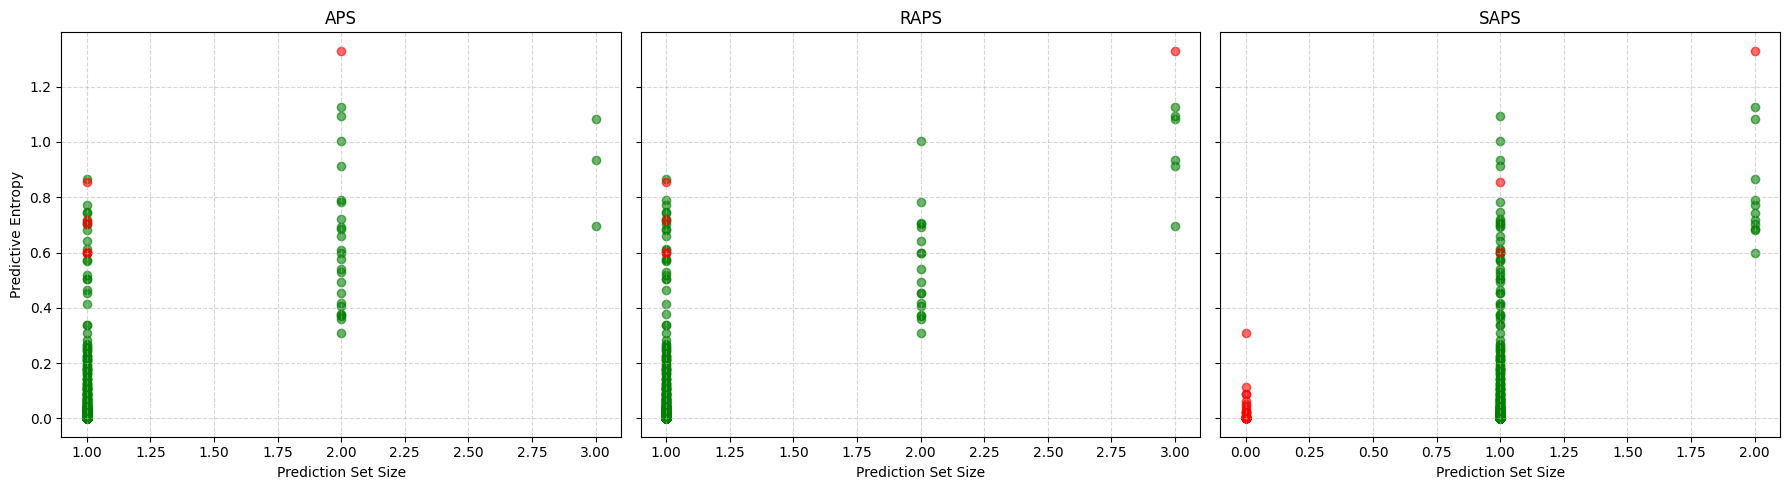

 <======================MC Dropout approach======================>
Method: APS
  Spearman correlation: 0.18371337927501946 p-value: 5.1280036011063e-06
  Kruskal-Wallis stat: 13.695389910555024 p-value: 0.001061900602391577
Method: RAPS
  Spearman correlation: 0.17041561642003802 p-value: 2.3964115440942866e-05
  Kruskal-Wallis stat: 11.719438345161418 p-value: 0.002852044502525632
Method: SAPS
  Spearman correlation: 0.09940301001704471 p-value: 0.014203430373420246
  Kruskal-Wallis stat: 6.887999172724303 p-value: 0.03193669597257387


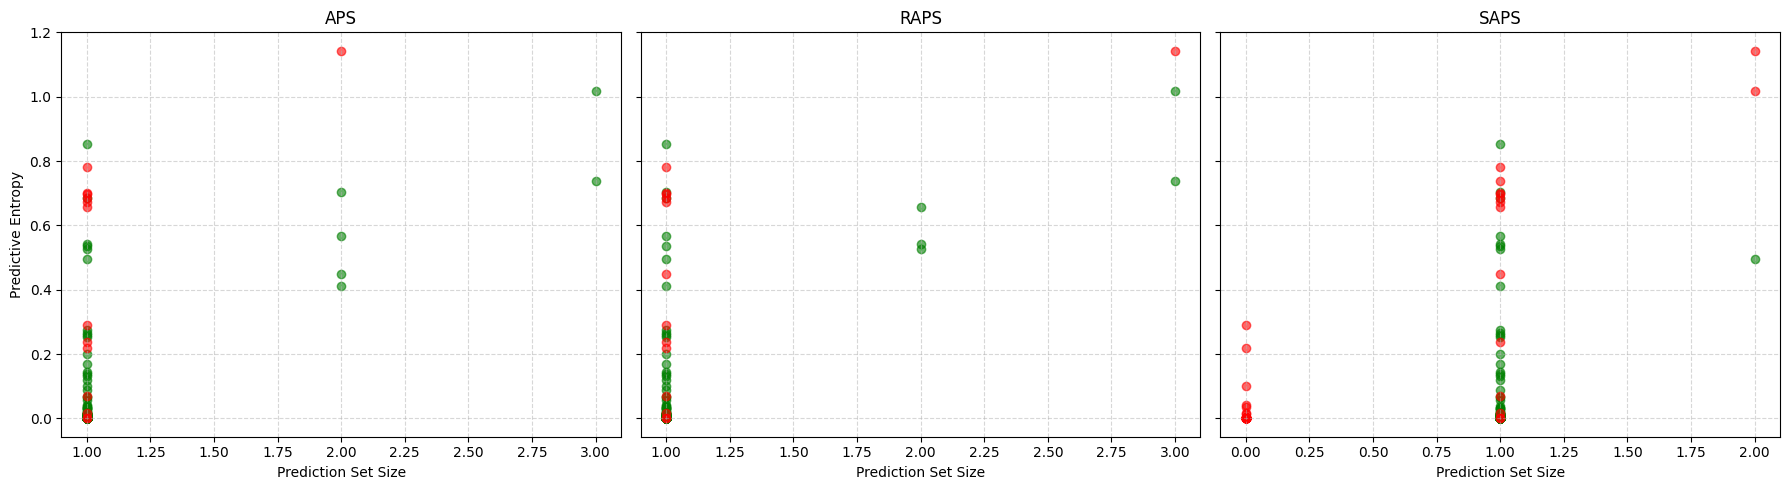

: 

In [ ]:
print(f" <======================Single approach======================>")
conformal_results_single = predictors['RAPS'].analyze_entropy_vs_set_size_all_methods(
    predictor_dict,
    test_probs=pipeline.test_results['single']['y_probas'],
    y_test=pipeline.test_results['single']['y_true']    
)

print(f" <======================Deep Ensemble approach======================>")
conformal_results_deep_ensemble = predictors['RAPS'].analyze_entropy_vs_set_size_all_methods(
    predictor_dict,
    test_probs=pipeline.test_results['deep_ensemble']['y_probas'],
    y_test=pipeline.test_results['deep_ensemble']['y_true']    
)
print(f" <======================MC Dropout approach======================>")
conformal_results_mc_dropout = predictors['RAPS'].analyze_entropy_vs_set_size_all_methods(
    predictor_dict,
    test_probs=pipeline.test_results['mc_dropout']['y_probas'],
    y_test=pipeline.test_results['mc_dropout']['y_true']    
)

# Step 6
Assess how effectively each base method flags OOD samples, comparing them using standard OOD metrics such as AUROC and AUPRC 

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import entropy
import requests, os
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class OODEvaluator:
    def __init__(self, models_dict, device):
        """
        Initialize the OOD evaluator.

        Parameters:
          - models_dict: dict with keys (e.g., 'single', 'mc_dropout', 'deep_ensemble')
                         and values as the corresponding fine-tuned models.
          - device: torch.device (e.g., torch.device("cuda") or torch.device("cpu"))
        """
        self.models_dict = models_dict
        self.device = device

    def get_probs(self, model, data_loader, approach='single'):
        """
        Computes predicted probabilities for all samples in data_loader using the given model(s).
        Inputs are forced to require gradients so that any internal hook registration is allowed.
        
        Parameters:
        model: a single model (for 'single' and 'mc_dropout') or a list of models (for 'deep_ensemble')
        data_loader: DataLoader containing the data.
        approach: one of 'single', 'mc_dropout', or 'deep_ensemble'.
        
        Returns:
        A numpy array of shape (n_samples, n_classes) containing the predicted probabilities.
        """
        if approach == 'single':
            model.eval()
            all_probs = []
            for batch in data_loader:
                if isinstance(batch, (list, tuple)):
                    inputs = batch[0]
                else:
                    inputs = batch
                inputs = inputs.to(self.device)
                inputs.requires_grad = True
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                all_probs.append(probs.detach().cpu().numpy())
        
        elif approach == 'mc_dropout':
            model.eval()
            # Activate dropout layers even in eval mode
            for m in model.modules():
                if isinstance(m, torch.nn.Dropout):
                    m.train()
            all_probs = []
            # Number of MC passes: use self.num_mc_passes if defined, else 10
            num_passes = getattr(self, 'num_mc_passes', 10)
            for batch in data_loader:
                if isinstance(batch, (list, tuple)):
                    inputs = batch[0]
                else:
                    inputs = batch
                inputs = inputs.to(self.device)
                inputs.requires_grad = True
                batch_probs = []
                with torch.no_grad():
                    for _ in range(num_passes):
                        outputs = model(inputs)
                        probs = torch.softmax(outputs, dim=1)
                        batch_probs.append(probs)
                # Average the predictions from each pass
                batch_probs = torch.stack(batch_probs, dim=0)  # shape: (num_passes, batch_size, n_classes)
                avg_probs = batch_probs.mean(dim=0)
                all_probs.append(avg_probs.cpu().numpy())
        
        elif approach == 'deep_ensemble':
            # Here, model is assumed to be a list of models.
            all_probs = []
            for batch in data_loader:
                if isinstance(batch, (list, tuple)):
                    inputs = batch[0]
                else:
                    inputs = batch
                inputs = inputs.to(self.device)
                batch_probs = []
                with torch.no_grad():
                    for m in model:
                        m.eval()
                        outputs = m(inputs)
                        probs = torch.softmax(outputs, dim=1)
                        batch_probs.append(probs)
                batch_probs = torch.stack(batch_probs, dim=0)  # shape: (ensemble_size, batch_size, n_classes)
                avg_probs = batch_probs.mean(dim=0)
                all_probs.append(avg_probs.cpu().numpy())
        else:
            raise ValueError("Unsupported approach: " + approach)
        
        return np.concatenate(all_probs, axis=0)


    def predictive_entropy(self, probs):
        """
        Compute predictive entropy for a probability vector.
        If probs is 2D (n_samples, n_classes), returns an array of entropies.
        """
        return -np.sum(probs * np.log(probs + 1e-12), axis=1)

    def evaluate_ood_for_model(self, model, id_loader, ood_loader, scoring_function=None):
        """
        Evaluates OOD detection performance for a single model using predictive entropy.

        Parameters:
          - model: the fine-tuned model.
          - id_loader: DataLoader for in-distribution (ID) data.
          - ood_loader: DataLoader for out-of-distribution (OOD) data.
          - scoring_function: function mapping a probability vector to a score.
                              Default is predictive entropy.

        Returns a dict with 'auroc' and 'auprc'.
        """
        if scoring_function is None:
            scoring_function = lambda prob: -np.sum(prob * np.log(prob + 1e-12))
        
        id_probs = self.get_probs(model, id_loader)   
        ood_probs = self.get_probs(model, ood_loader) 
        
        id_scores = np.array([scoring_function(prob) for prob in id_probs])
        ood_scores = np.array([scoring_function(prob) for prob in ood_probs])
        
        labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
        scores = np.concatenate([id_scores, ood_scores])
        
        auroc = roc_auc_score(labels, scores)
        auprc = average_precision_score(labels, scores)
        print(f"OOD Evaluation for model: AUROC = {auroc:.3f}, AUPRC = {auprc:.3f}")
        return {'auroc': auroc, 'auprc': auprc}

    def evaluate_all(self, id_loader, ood_loader, scoring_function=None):
        """
        Evaluates OOD detection performance for each model in models_dict.

        Parameters:
          - id_loader: DataLoader for in-distribution data.
          - ood_loader: DataLoader for OOD data.
          - scoring_function: optional function for computing the score from probabilities.

        Returns a dictionary mapping each method name to its AUROC and AUPRC.
        """
        results = {}
        for method, model in self.models_dict.items():
            print(f"Evaluating OOD for {method} approach...")
            metrics = self.evaluate_ood_for_model(model, id_loader, ood_loader, scoring_function=scoring_function)
            results[method] = metrics
        return results

    @staticmethod
    def download_and_save_image(url, save_path):
        """
        Downloads an image from a URL and saves it to the specified path.
        """
        response = requests.get(url)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
        else:
            print(f"Failed to download image from {url}. Code: {response.status_code}")

    @staticmethod
    def create_ood_dataset(image_urls, save_dir):
        """
        Downloads images from a list of URLs and saves them in the specified directory.
        """
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        for i, url in enumerate(image_urls):
            image_name = f"ood_{i}.jpg"
            save_path = os.path.join(save_dir, image_name)
            OODEvaluator.download_and_save_image(url, save_path)
            print(f"Downloaded and saved {image_name}")

class OODImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.filenames = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
                          if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img = Image.open(self.filenames[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

models_dict = {
    'single': single_finetuned_model,
    'mc_dropout': mcdropout_finetuned_model,
    'deep_ensemble': de_finetuned_models
}

ood_evaluator = OODEvaluator(models_dict, device=DEVICE)

ood_dataset_dir = "ood_dataset"
image_urls = [
    "https://cdn.pixabay.com/photo/2024/02/24/17/37/lemons-8594421_1280.jpg",
    "https://cdn.pixabay.com/photo/2022/04/05/17/06/butterfly-7114037_640.jpg",
    "https://cdn.pixabay.com/photo/2025/03/21/21/22/roche-9485693_640.jpg",
    "https://cdn.pixabay.com/photo/2021/12/04/20/59/animal-6845972_1280.jpg",
    "https://cdn.pixabay.com/photo/2025/02/25/04/25/desert-9429492_640.jpg"
]
OODEvaluator.create_ood_dataset(image_urls, ood_dataset_dir)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
ood_dataset = OODImageDataset(ood_dataset_dir, transform=transform)
ood_loader = DataLoader(ood_dataset, batch_size=3, shuffle=False)

ood_metrics = ood_evaluator.evaluate_all(id_loader=pipeline.test_loader, ood_loader=ood_loader)

methods = list(ood_metrics.keys())
aurocs = [ood_metrics[m]['auroc'] for m in methods]
auprcs = [ood_metrics[m]['auprc'] for m in methods]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].bar(methods, aurocs, color='skyblue')
axes[0].set_title("OOD AUROC")
axes[0].set_ylabel("AUROC")
axes[0].set_ylim(0, 1)
axes[1].bar(methods, auprcs, color='lightgreen')
axes[1].set_title("OOD AUPRC")
axes[1].set_ylabel("AUPRC")
axes[1].set_ylim(0, 1)
plt.tight_layout()
plt.show()


Downloaded and saved ood_0.jpg
Downloaded and saved ood_1.jpg
Downloaded and saved ood_2.jpg
Downloaded and saved ood_3.jpg
Downloaded and saved ood_4.jpg
Evaluating OOD for single approach...
OOD Evaluation for model: AUROC = 0.832, AUPRC = 0.078
Evaluating OOD for mc_dropout approach...
